# Table of Contents

[Introduction](#1)

[Initialization](#2)

[Section 1: Loading & Preparing the Data](#3)

[Section 2: EDA (Exploratory Data Analysis)](#4)

[Section 3: Evaluation Procedure](#5)

[Section 4: Normalization](#6)

[Section 5: Train/Test Split](#7)

[Section 6: Working with Models](#8)

[Section 7: My Reviews](#9)

[Conclusion](#10)

# Introduction <a id=1></a>

The **Film Junky Union**, a new and edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. 

My goal is to train a model that can detect whether a review is positive or negative. 

I will use a dataset of IMDB movie reviews with polarity labelling to build a model for classifying positive and negative reviews. 

The model needs to have an F1 score of at least 0.85.

# Initialization <a id=2></a>

In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import spacy
import time

from lightgbm import LGBMClassifier
from nltk.corpus import stopwords
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

# The next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# This is to use progress_apply. Read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

# Section 1: Loading & Preparing the Data <a id=3></a>

Just before I load the data, it would be a good idea to provide a description of the rows:

`tconst` = This appears to be some kind of identification.

`title_type` = The kind of media being reviewed, e.g. movie, TV series, TV mini-series, etc.

`primary_title` = The most commonly known name of the media, e.g. the English translation of a foreign title.

`original_title` = The original name of the media, e.g. the name in the foreign language of the country it was made in.

`start_year` = The year of release of the media.

`end_year` = The most recent year that a review for the media was posted.

`runtime_minutes` = The length of the media in minutes.	

`is_adult` = Intended for adults only: "0" means "False" and "1" means "True". 

`genres` = The genre(s) of the media, e.g. Action, Comedy, Horror, Musical, etc.

`average_rating` = The average rating of the media, where ratings are on a scale from 1 to 10.

`votes` = The total number of ratings.

`review` = The text of the review, which has not been lemmatized.

`rating` = The rating, on a scale from 1 to 10, given by the person who wrote the review.

`sp` = Either "pos" or "neg", indicating whether the review is positive or negative, respectively.

`pos` = The <b>TARGET</b>: "0" for negative reviews and "1" for positive reviews.

`ds_part` = Either "train" or "test", indicating which set the row belongs to.

`idx` = This appears to be either (another) identification, or an abbreviation for "index".

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep = '\t', dtype = {'votes': 'Int64'})

Are any of the rows in the dataframe exact duplicates? If so, they should be dropped.

In [5]:
df_reviews[df_reviews.duplicated()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx


Since the above code displays an empty dataframe, that means there are no exact duplicate rows. Great!

In my opinion, it is always a good idea to display a random sample of rows of the dataframe in order to get an idea of how the data is organized and formatted.

In [6]:
df_reviews.sample(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
2991,tt0085178,movie,Ardh Satya,Ardh Satya,1983,\N,130,0,"Crime,Drama",8.2,1497,Govind Nihalani's directorial venture of Vijay...,10,pos,1,train,10109
14029,tt0064354,movie,Futz,Futz,1969,\N,92,0,Comedy,4.6,64,"""All the world's a stage and its people actors...",10,pos,1,train,3
14986,tt0225899,video,Granny,Granny,1999,\N,58,0,Horror,3.2,404,"This film is so awful it is funny, not quite t...",2,neg,0,test,1506
10644,tt0473064,movie,Doomsday: The Sinking of Japan,Nihon chinbotsu,2006,\N,135,0,"Adventure,Drama,Sci-Fi",5.6,1338,I don't know what Dick steel was talking about...,10,pos,1,test,9512
34031,tt0429487,tvSpecial,The 77th Annual Academy Awards,The 77th Annual Academy Awards,2005,\N,194,0,Music,6.2,1088,I firmly believe that the best Oscar ceremony ...,4,neg,0,train,4314
15871,tt0390079,movie,Hari Om,Hari Om,2004,\N,108,0,"Comedy,Romance",6.3,110,"On one level, Hari Om is a film using a famili...",8,pos,1,test,3655
17217,tt0435665,tvMovie,House of the Dead 2,House of the Dead 2,2005,\N,95,0,"Action,Comedy,Horror",3.7,5545,Isn't it strange how crap-movies always tend t...,3,neg,0,test,7712
41144,tt0423088,short,The Romeo Division,The Romeo Division,2004,\N,25,0,"Action,Short",5.5,22,...here comes the Romeo Division to change the...,10,pos,1,train,1781
21199,tt0076342,movie,MacArthur,MacArthur,1977,\N,130,0,"Biography,Drama,History",6.6,4204,Name just says it all. I watched this movie wi...,9,pos,1,train,3036
19838,tt0848538,movie,Kung Fu Dunk,Gong fu guan lan,2008,\N,100,0,"Comedy,Sport",4.9,3209,The movie is absolutely silly. But were you ex...,7,pos,1,train,7593


Are any of the **title_type** values not **movie**? If not, then this column should be dropped.

In [7]:
df_reviews['title_type'].value_counts()

movie           36861
tvMovie          2892
video            2742
tvSeries         2246
short             887
tvMiniSeries      713
tvEpisode         635
tvSpecial         183
videoGame         154
tvShort            18
Name: title_type, dtype: int64

There are a few things about this column that concern me:

(1) 154 rows are about a video game, and since **Film Junky Union** is intended for movie enthusiasts, I don't think these 154 rows belong in the dataframe. 

(2) Similarly, I don't think the 183 rows about TV specials belong in the dataframe. When I hear "TV special", I think of award shows (e.g. the Academy Awards), one-time performances (e.g. the SuperBowl halftime show), and interviews (e.g. 60 Minutes with Tom Cruise). None of these are movies.

(3) I don't see any good reason why **short** and **tvShort** should be separate values, especially since only 18 rows are about a **tvShort**.

The next line of code drops the rows with a **title_type** of **tvSpecial** or **videoGame**, and also renames all of the **tvShort** values to simply **short**.

In [8]:
df_reviews = df_reviews[~(df_reviews['title_type'] == 'tvSpecial')]
df_reviews = df_reviews[~(df_reviews['title_type'] == 'videoGame')]
df_reviews['title_type'] = df_reviews['title_type'].replace('tvShort', 'short')

What is the earliest **start_year** value in this dataframe? What is the latest? Let's find out!

In [9]:
print("In the df_reviews dataframe, the years of release range from", 
      df_reviews['start_year'].min(), "to", str(df_reviews['start_year'].max()) + ".")

In the df_reviews dataframe, the years of release range from 1894 to 2010.


Are any of the **end_year** values not **\N**? If not, then this column should be dropped.

In [10]:
df_reviews['end_year'].value_counts()

\N      44715
2007      225
2008      190
2006      140
2009      130
2010      124
2003      102
2002       97
2005       96
1996       96
2004       84
2001       75
1995       69
1999       61
1983       55
1989       49
2012       47
1985       40
2000       40
1976       37
1987       35
1994       34
1986       33
2017       32
1998       27
1990       26
2011       22
1982       21
2013       19
2014       17
1975       17
1984       16
1981       16
1997       16
1960       16
1973       15
1979       15
1988       14
1991       14
1993       13
1977       10
1978        9
1965        7
1972        7
1974        7
1970        7
1969        6
2020        6
1961        6
1957        5
1980        5
2016        5
1955        4
1966        4
2018        4
2019        4
1962        3
1953        2
1968        2
1959        1
Name: end_year, dtype: int64

Though it turns out that not all of the **end_year** values are **\N**, I don't see the point of this column. Essentially, this column is indicating which year is the most recent year that a particular media received a review. I don't see why that detail matters, however. The purpose of the machine learning model I will build is to identify if the review is positive or negative, and this is not something that depends on the most recent year that the media received a review. This column gets dropped in the next line.

In [11]:
df_reviews.drop(columns = 'end_year', inplace = True)

Are any of the **is_adult** values not **0**? If not, then this column should be dropped.

In [12]:
df_reviews['is_adult'].value_counts()

0    46912
1       82
Name: is_adult, dtype: int64

I have a feeling that **is_adult** is meant to indicate whether or not the media is pornographic. How many unique titles have an **is_adult** value of 1?

In [13]:
len(df_reviews[df_reviews['is_adult'] == 1]['primary_title'].unique())

19

Now let's display one row of each these 19 media to see if I am correct that these are pornographic. 

In [14]:
df_reviews[df_reviews['is_adult']==1][['primary_title','start_year','genres']].drop_duplicates('primary_title').sample(19)

,primary_title,start_year,genres
30296,Sex Files: Sexecutioner,1998,Drama
30331,Sex Wish,1976,"Adult,Horror,Thriller"
26724,Porno Holocaust,1981,"Adult,Horror"
44300,Tumbling Doll of Flesh,1998,"Adult,Horror"
29488,Sandra: The Making of a Woman,1970,Drama
24027,New Wave Hookers,1985,"Adult,Comedy,Fantasy"
19915,La Blue Girl,1992,"Action,Adult,Animation"
19707,Knothole,1971,"Adult,Short"
36276,The Devil in Miss Jones,1973,"Adult,Drama,Fantasy"
1821,Alice in Wonderland: An X-Rated Musical Fantasy,1976,"Adult,Comedy,Fantasy"


For the majority of these, it is very reasonable to suspect that they are pornographic, either because the title suggests it, e.g. "Alice in Wonderland: An **X-Rated** Musical Fantasy", or because the **genres** values includes "Adult", or both.

Since only a tiny percentage of the rows in the dataframe have an **is_adult** value of 1 (82/47331 ≈ 0.173%), I don't think the **is_adult** column contributes enough to the dataframe for it to be worth keeping. The next line drops this column.

In [15]:
df_reviews.drop(columns = 'is_adult', inplace = True)

What is the minimum **rating** that is considered positive? This is a detail that is crucial to know.

In [16]:
df_reviews.groupby('rating')['sp'].value_counts()

rating  sp 
1       neg    9557
2       neg    4330
3       neg    4697
4       neg    5059
7       pos    4569
8       pos    5532
9       pos    4308
10      pos    8942
Name: sp, dtype: int64

Interestingly, none of the 47,331 rows in the dataframe have a rating value of 5 or 6. Maybe this is because it is ambiguous how to classify a rating value of 5 or 6. Some may argue that a 5 (out of 10) is "negative", but others would argue that a 5 is "neutral" (i.e. not negative nor positive). Furthermore, some may argue that a 6 (out of 10) is "neutral" while others would say that a 6 is "positive" (albeit only slightly positive).

One thing is for sure: 7 is the lowest possible positive review value.

The **info()** function is a great way to gain more insight about a dataframe.

In [17]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46994 entries, 0 to 47330
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           46994 non-null  object 
 1   title_type       46994 non-null  object 
 2   primary_title    46994 non-null  object 
 3   original_title   46994 non-null  object 
 4   start_year       46994 non-null  int64  
 5   runtime_minutes  46994 non-null  object 
 6   genres           46994 non-null  object 
 7   average_rating   46992 non-null  float64
 8   votes            46992 non-null  Int64  
 9   review           46994 non-null  object 
 10  rating           46994 non-null  int64  
 11  sp               46994 non-null  object 
 12  pos              46994 non-null  int64  
 13  ds_part          46994 non-null  object 
 14  idx              46994 non-null  int64  
dtypes: Int64(1), float64(1), int64(4), object(9)
memory usage: 5.8+ MB


All of the Dtypes make sense for their corresponding columns, which is great to see!

That aside, I will rename the **sp** column to **p_or_n** because this, I think, makes it easier to tell what this column contributes to the dataframe.

In [18]:
df_reviews.rename(columns = {'sp': 'p_or_n'}, inplace = True)

In [19]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46994 entries, 0 to 47330
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           46994 non-null  object 
 1   title_type       46994 non-null  object 
 2   primary_title    46994 non-null  object 
 3   original_title   46994 non-null  object 
 4   start_year       46994 non-null  int64  
 5   runtime_minutes  46994 non-null  object 
 6   genres           46994 non-null  object 
 7   average_rating   46992 non-null  float64
 8   votes            46992 non-null  Int64  
 9   review           46994 non-null  object 
 10  rating           46994 non-null  int64  
 11  p_or_n           46994 non-null  object 
 12  pos              46994 non-null  int64  
 13  ds_part          46994 non-null  object 
 14  idx              46994 non-null  int64  
dtypes: Int64(1), float64(1), int64(4), object(9)
memory usage: 5.8+ MB


There are two rows with a null **average_rating** value, as well as two rows with a null **votes** value. Let's investigate these rows...

In [20]:
df_reviews[(df_reviews['average_rating'].isnull())|(df_reviews['votes'].isnull())]

,tconst,title_type,primary_title,original_title,start_year,runtime_minutes,genres,average_rating,votes,review,rating,p_or_n,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


Interestingly, the two rows with a null **average_rating** value are also the two rows with a null **votes** value.

I am not sure, but if I had to guess, "Mila Ass Painting" is a pornographic film that very few people have watched. This would explain why it has no votes, and hence no average rating.

I wonder if "Mila Ass Painting" appears in any other rows? If so, maybe those other rows have a non-null **average_rating** and/or **votes** value.

In [21]:
df_reviews[df_reviews['original_title'] == "Mila Ass Painting"]

,tconst,title_type,primary_title,original_title,start_year,runtime_minutes,genres,average_rating,votes,review,rating,p_or_n,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


No, it turns out that the two rows I displayed before are the only rows that are about "Mila Ass Painting". 

These rows can be dropped without negative consequences. 

In [22]:
df_reviews = df_reviews[~(df_reviews['original_title'] == "Mila Ass Painting")]

# Section 2: EDA (Exploratory Data Analysis) <a id=4></a>

Let's check the number of movies and reviews over the years. Specifically, let's check these distributions from 1960 to 2010. Though I could begin the plots at the year 1894, I will not do this for three reasons:

(1) Including all of the years will make the plots look squished, and hence difficult to read.

(2) The number of movies released each year before 1960 was low, and therefore one can easily imagine what that portion of the distribution would look like.

(3) According to Wikipedia, **NBC Saturday Night at the Movies**, which was the first TV show to show (relatively) recent movies from major studios, premiered in 1961. Hence, I wouldn't be surprised if the number of movies and reviews surged not long afterwards.

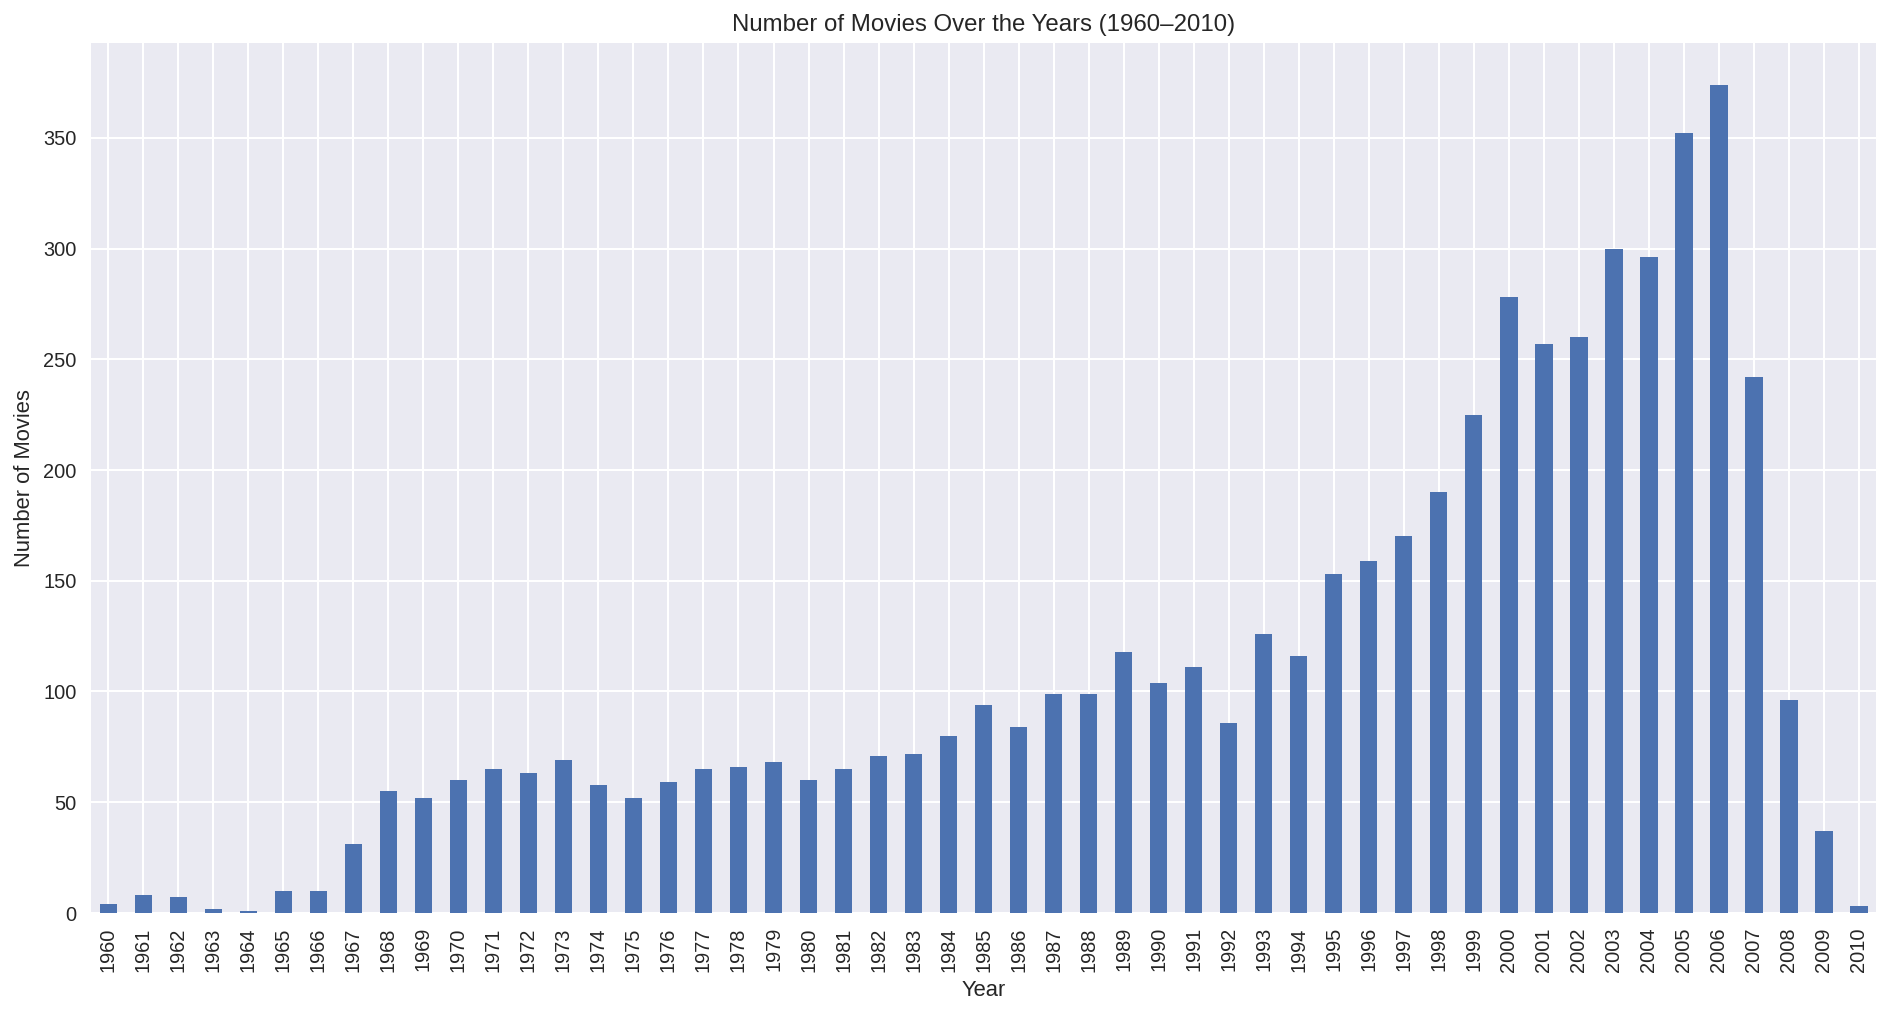

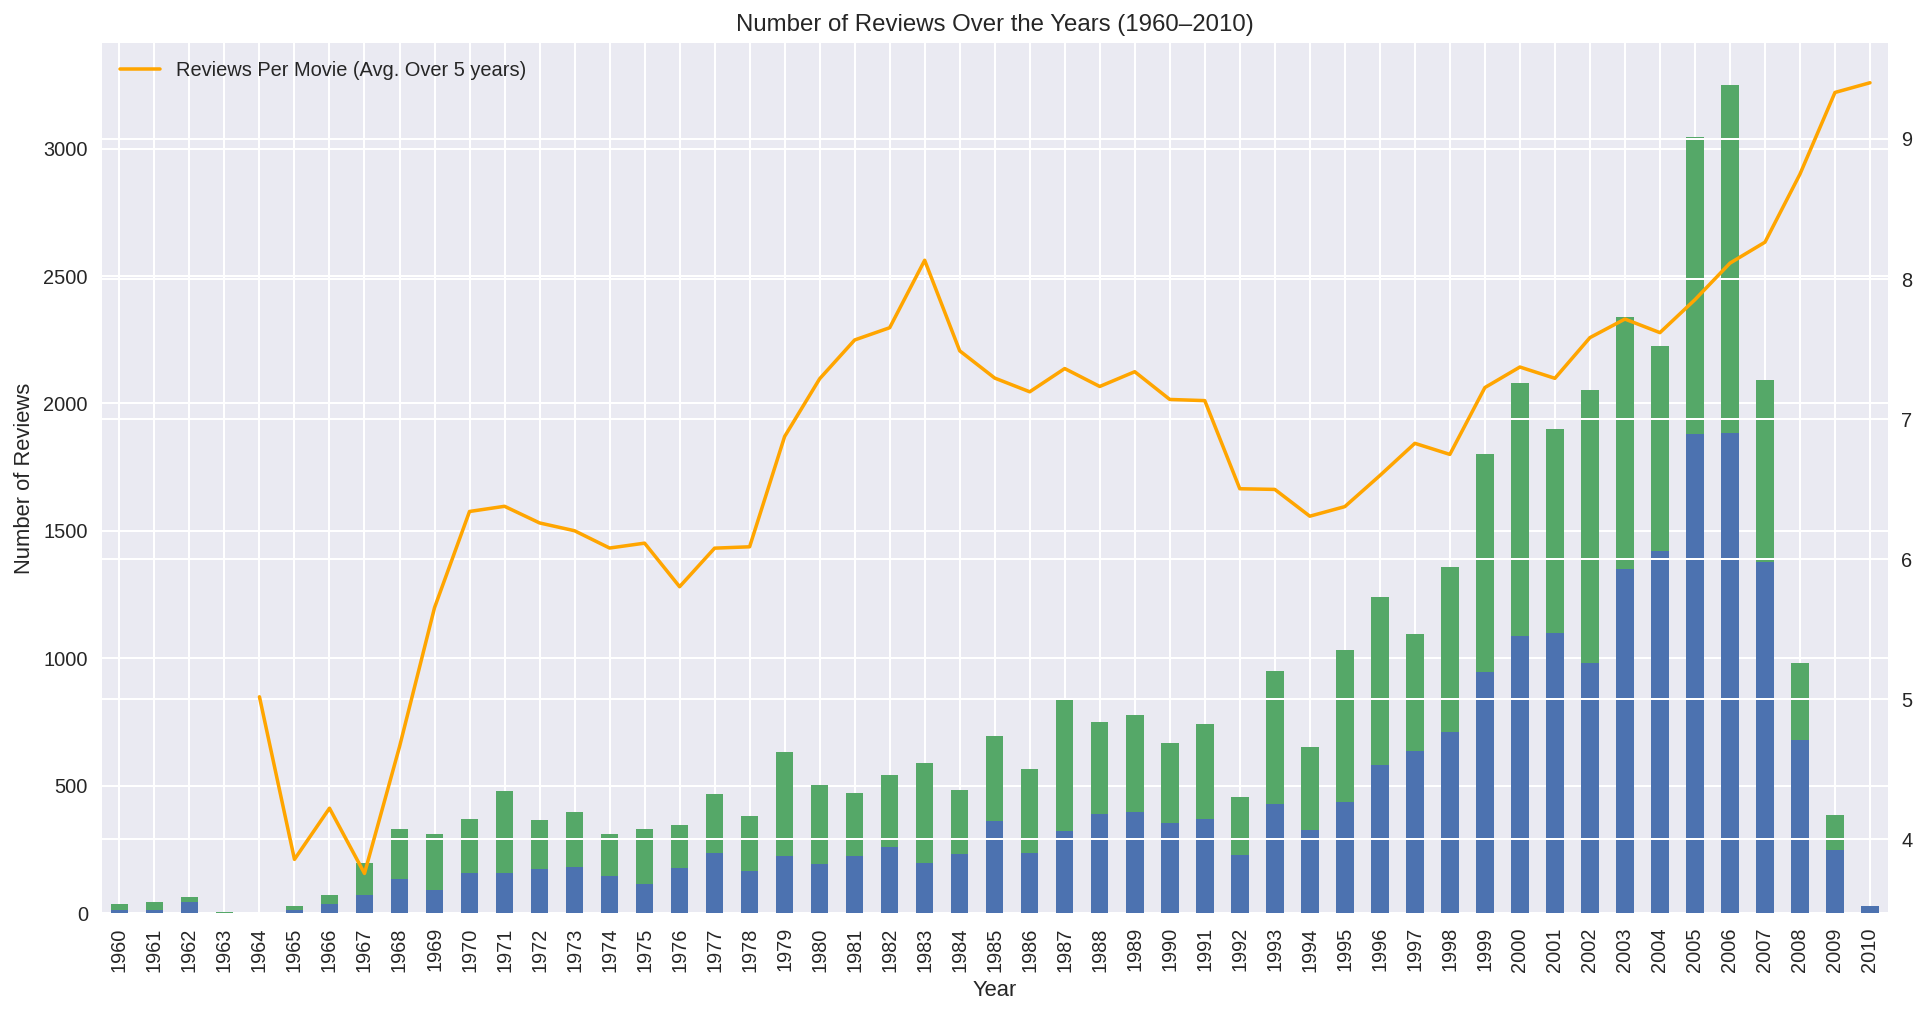

In [23]:
df_reviews_since_1960 = df_reviews[(df_reviews['start_year'] >= 1960) & (df_reviews['start_year'] <= 2010)]


fig1, ax1 = plt.subplots(figsize = (16, 8))

dft1 = df_reviews_since_1960[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index = np.arange(1960, 2011)).fillna(0)
dft1.plot(kind = 'bar', ax = ax1)
ax1.set_title('Number of Movies Over the Years (1960–2010)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Movies')


fig2, ax2 = plt.subplots(figsize = (16, 8))

dft2 = df_reviews_since_1960.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index = np.arange(1960, 2011)).fillna(0)
dft2.plot(kind = 'bar', stacked = True, label = '#reviews (neg, pos)', ax = ax2)
dft2_movies = df_reviews_since_1960['start_year'].value_counts().sort_index()
dft2_movies = dft2_movies.reindex(index = np.arange(1960, 2011)).fillna(0)


dft3 = (dft2_movies / dft1).fillna(0)
axt = ax2.twinx()
dft3.reset_index(drop = True).rolling(5).mean().plot(color='orange', label='Reviews Per Movie (Avg. Over 5 years)', ax=axt)


lines, labels = axt.get_legend_handles_labels()
ax2.legend(lines, labels, loc = 'upper left')
ax2.set_title('Number of Reviews Over the Years (1960–2010)')
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Reviews')


plt.show()

Note that in the **Number of Reviews Over the Years (1960–2010)** graph, the blue bars refer to negative reviews, and the green bars refer to positive reviews.

It appears as though the number of movies, and consequently the number of reviews, increased significantly from 1960 to 1994, and then from 1994 onward the numbers surged. With that said, for some reason the dataframe has a relatively small number of movies from 2007, 2008, 2009, and 2010. In fact, the drop from 2006 to 2010 is <u>MASSIVE</u>! 

My best guess is that the dataset was collected in 2010, which would at least explain why the year 2010 has so few movies and reviews. I would venture to say that the dataset might have been collected early in the year 2010, possibly in January or February, by which point only a relatively small number of movies would have been released thus far that year.

Now let's check the distribution of number of reviews per movie with both the exact counting and KDE (kernel density estimation).

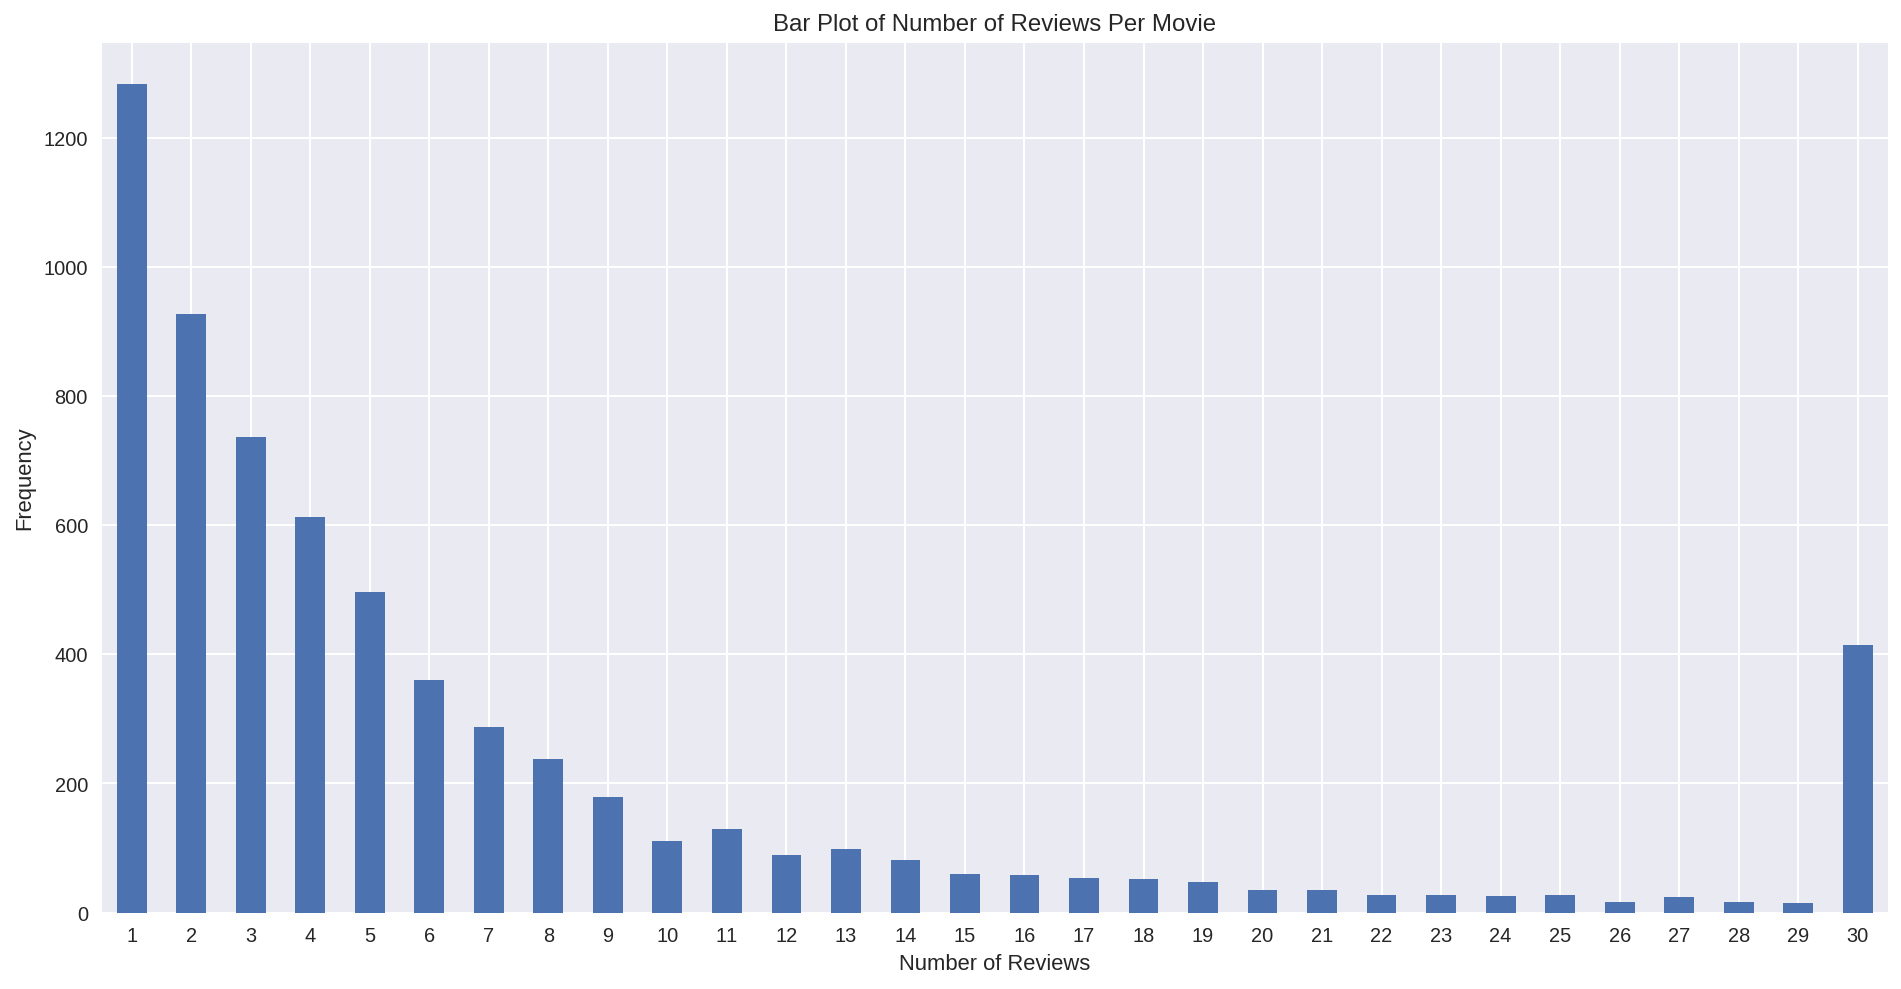

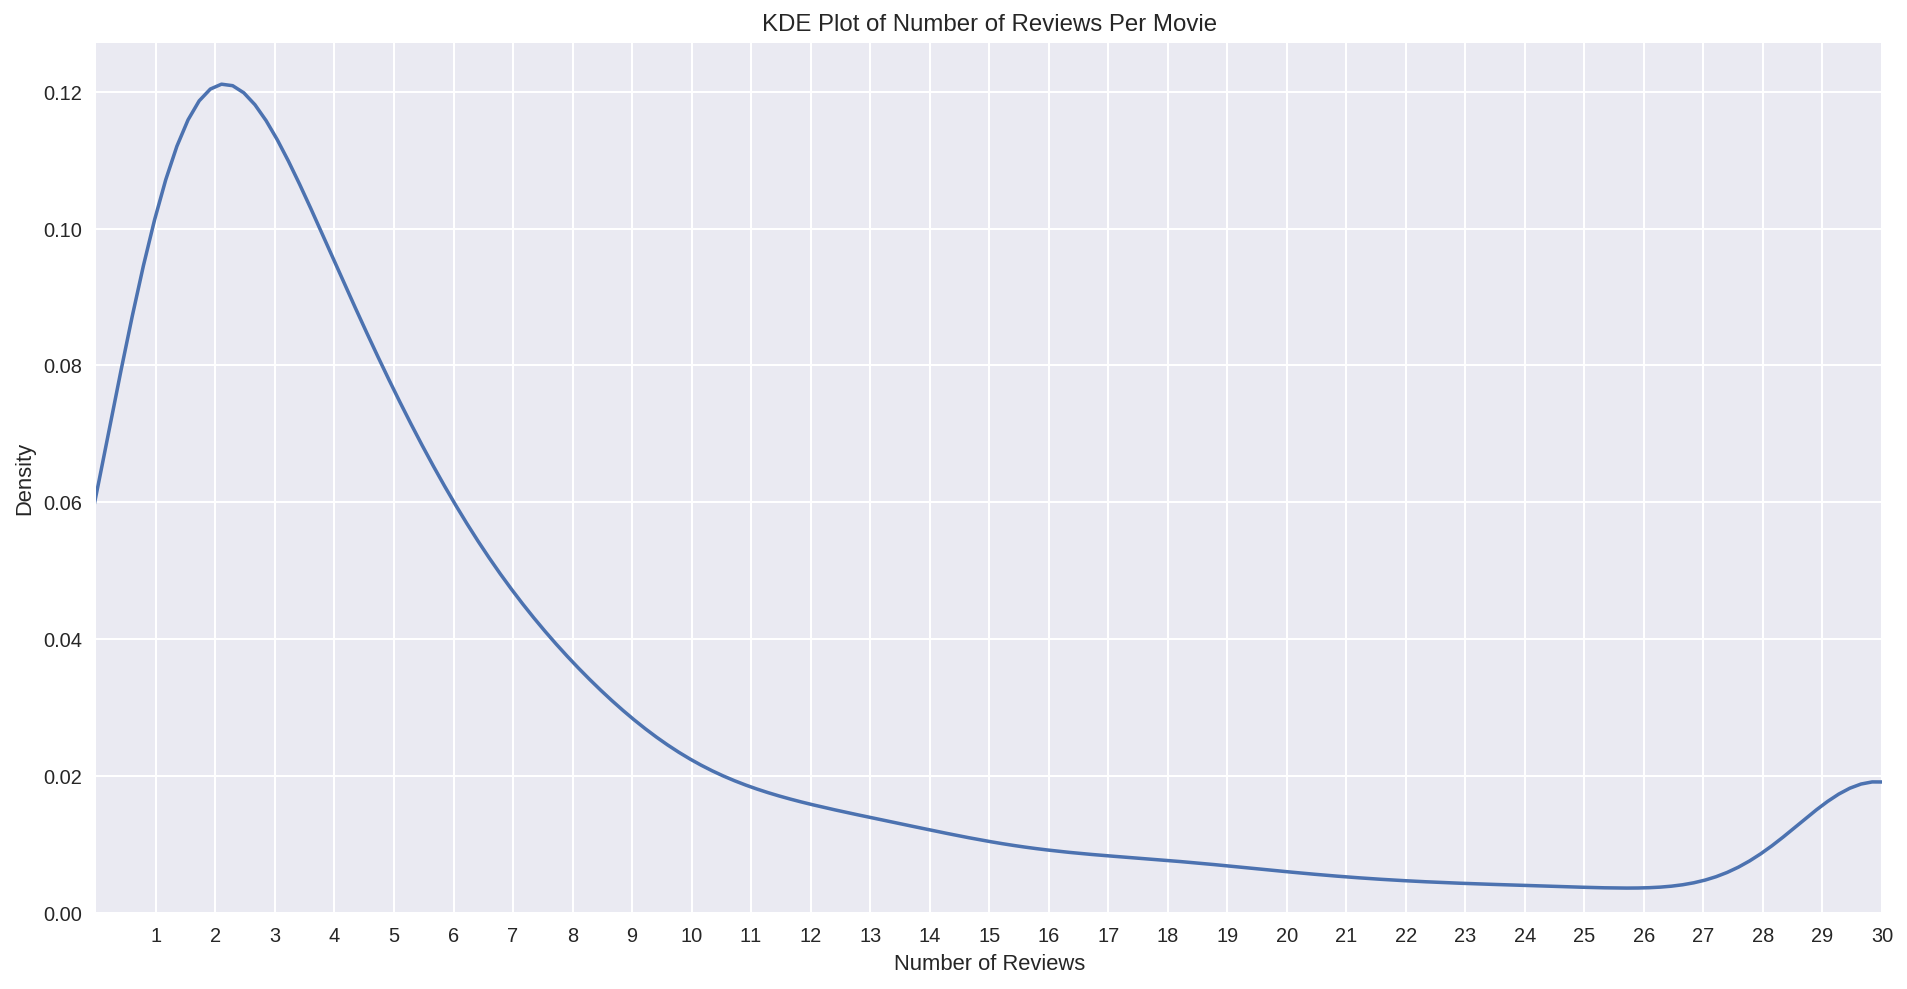

In [24]:
fig1, ax1 = plt.subplots(figsize = (16, 8))
dft1 = df_reviews.groupby('tconst')['review'].count().value_counts().sort_index()
dft1.plot.bar(ax = ax1)
ax1.set_title('Bar Plot of Number of Reviews Per Movie')
ax1.set_xlabel('Number of Reviews')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 0)
ax1.set_ylabel('Frequency')


fig2, ax2 = plt.subplots(figsize = (16, 8))
dft2 = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft2, ax = ax2)
ax2.set_title('KDE Plot of Number of Reviews Per Movie')
ax2.set_xlabel('Number of Reviews')
ax2.set_xlim(0, 30)
ax2.set_xticks(range(1, 31))


plt.show() 

The two distributions are similar, as I would have expected. Writing a review takes time, and it is something where there is arguably no incentive to do it, so I am not surprised that so many movies have so few reviews. 

With that said, I find it intriguing that a relatively high number of movies have 30 reviews. Maybe this is because the most popular movies receive a lot more reviews than their less popular counterparts, and the dataset deliberately caps the number of reviews for one movie at 30 so that the dataset does not consist of a massive number of reviews for the same popular movies and just a few for the majority of the movies.

Is there a class imbalance with the target column, **pos**? If so, I need to come up with a plan for how to handle it.

In [25]:
df_reviews['pos'].value_counts()

0    23643
1    23349
Name: pos, dtype: int64

Excellent! The ratio between negative reviews (0) and positive reviews (1) is approximately 1.0126 to 1, which is very close to 1 to 1. This means there is no class imbalance!

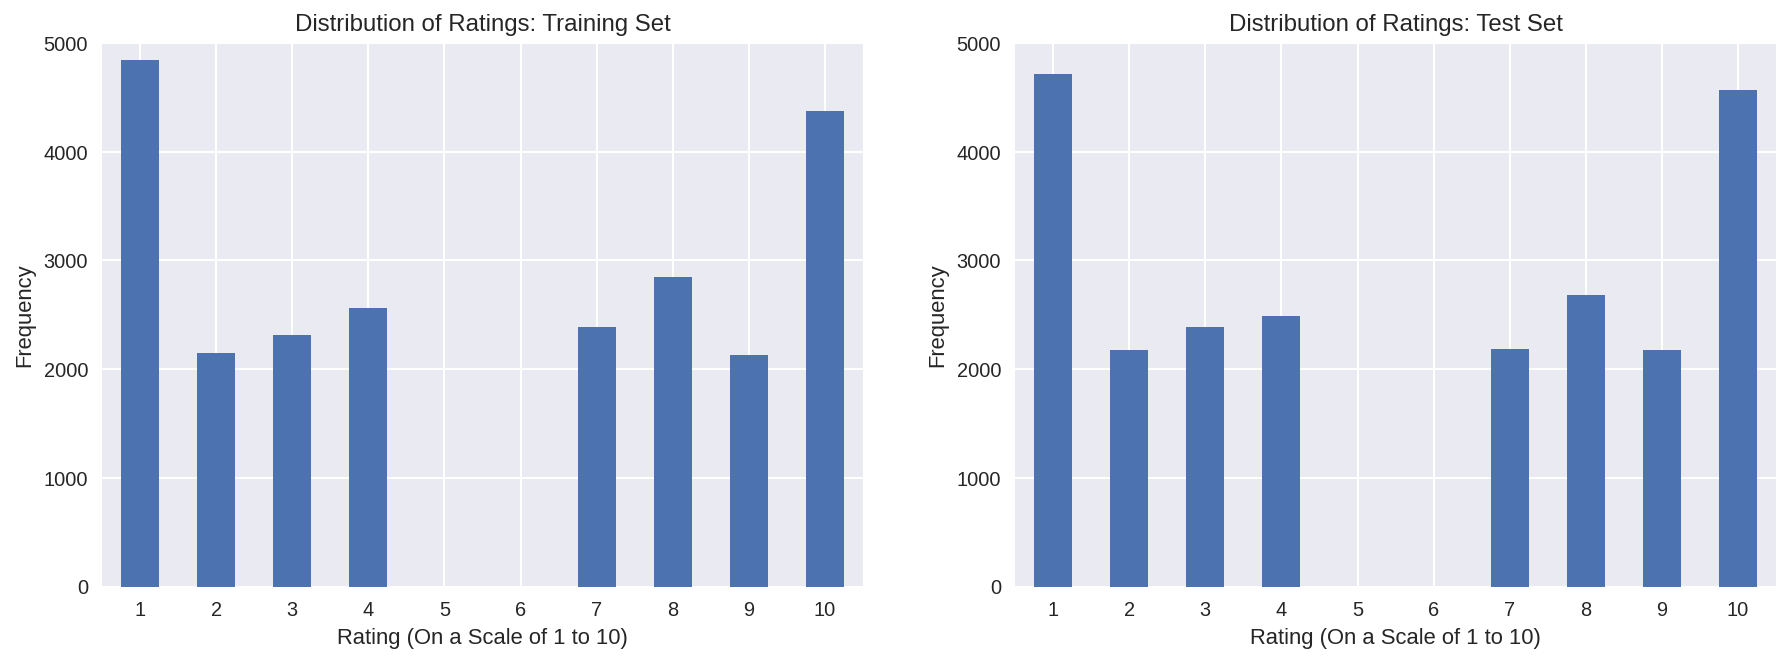

In [26]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))


ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index = np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax = ax)
ax.set_title('Distribution of Ratings: Training Set')
ax.set_xlabel('Rating (On a Scale of 1 to 10)')
ax.set_ylabel('Frequency')
ax.set_ylim([0, 5000])


ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index = np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax = ax)
ax.set_title('Distribution of Ratings: Test Set')
ax.set_xlabel('Rating (On a Scale of 1 to 10)')
ax.set_ylabel('Frequency')
ax.set_ylim([0, 5000])


for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)

Great! The distributions of ratings are approximately equal, so there is no class imbalance with the **rating** values.

Now let's look at the distribution of negative and positive reviews over the years for the two sets of the dataset.

(<u>SIDE NOTE</u>: I decided to include **ALL** of the years in the plots below because it is important to check and see if the two sets have similar enough distributions across all years, or not.) 

Text(0, 0.5, 'Number of Reviews')

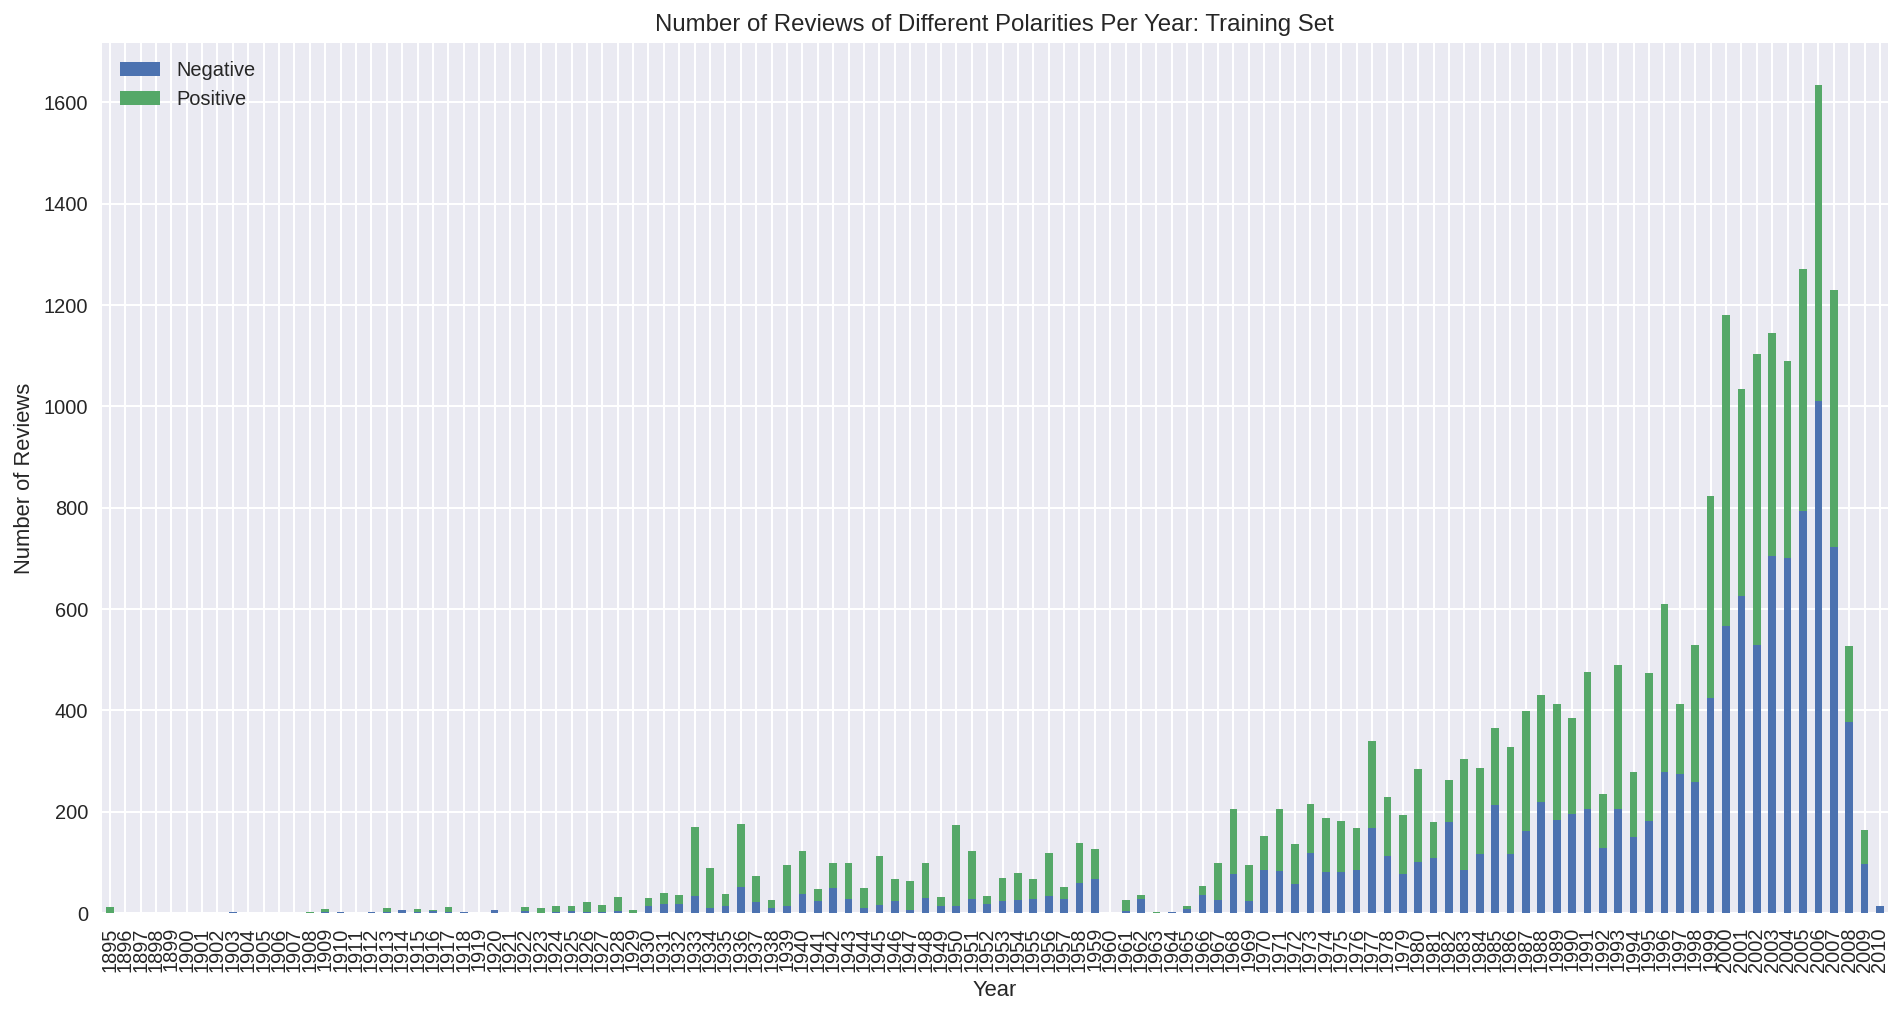

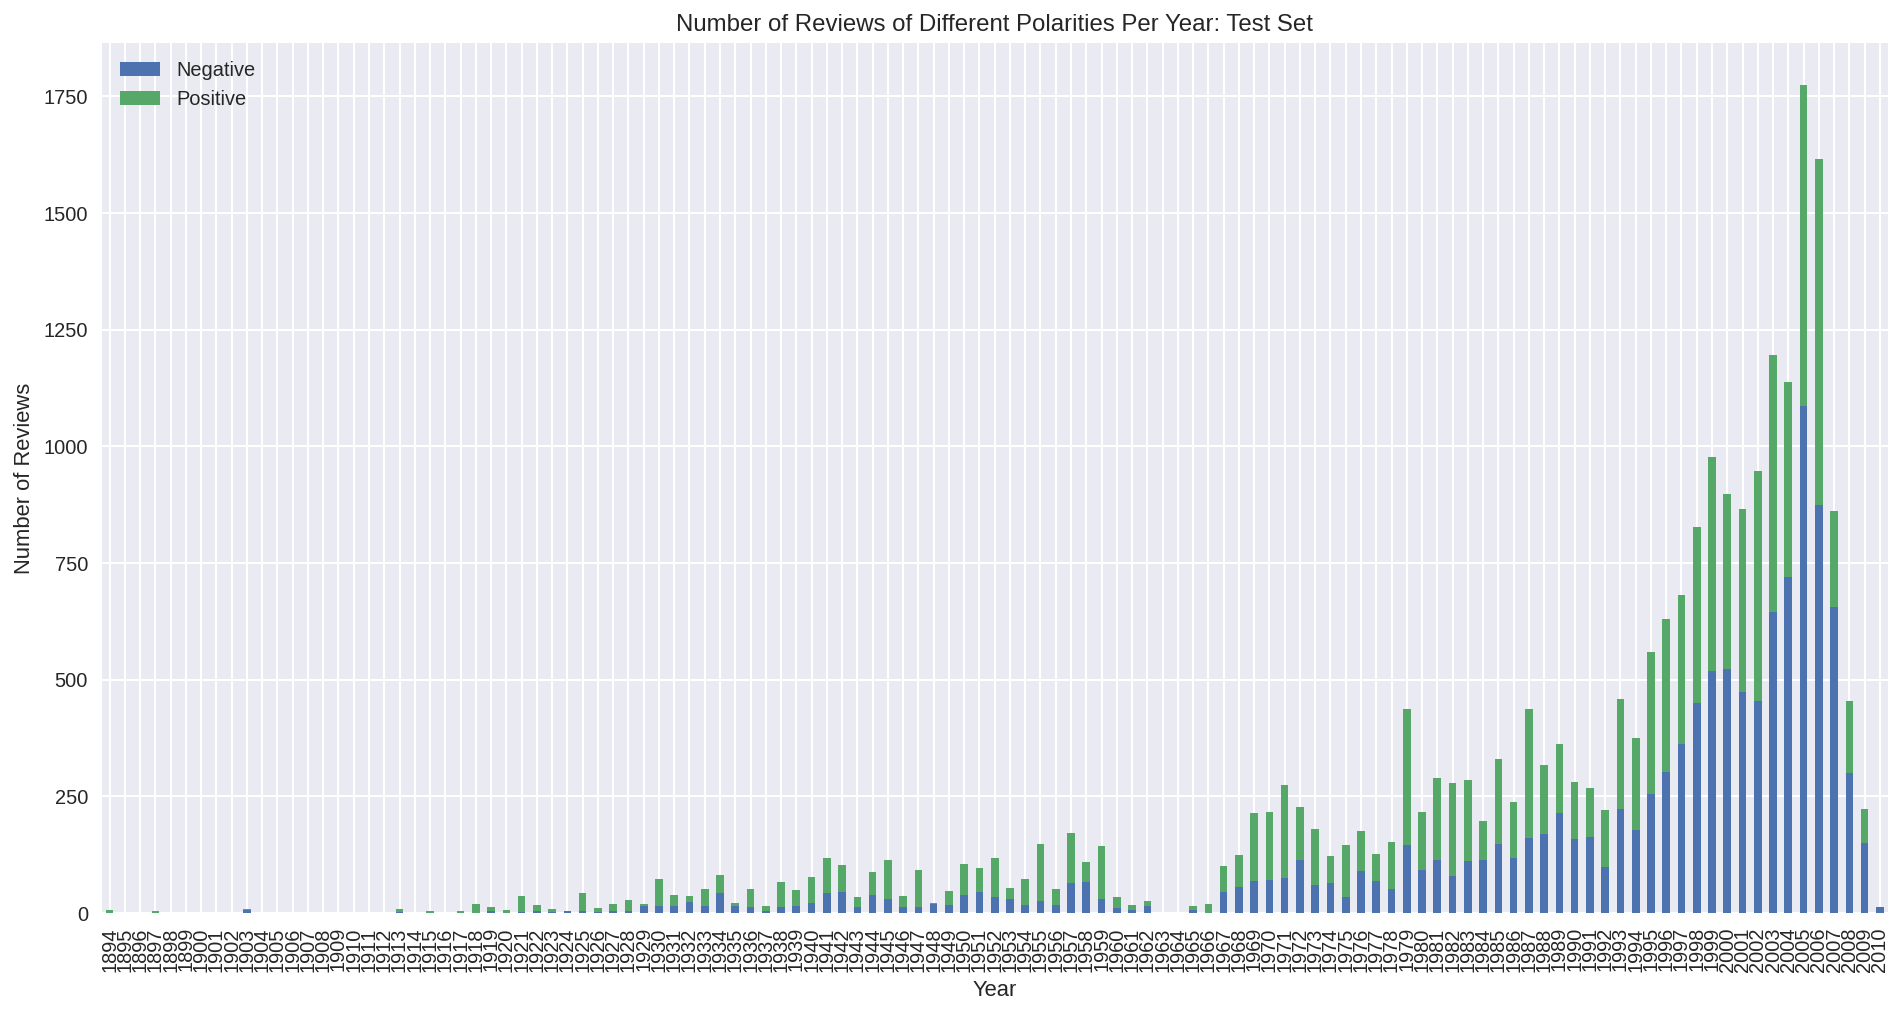

In [27]:
fig1, ax1 = plt.subplots(figsize = (16, 8))

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index = np.arange(dft.index.min(), max(dft.index.max(), 2011))).fillna(0)
dft.plot(kind = 'bar', stacked = True, ax = ax1)
ax1.legend(['Negative', 'Positive'])
ax1.set_title('Number of Reviews of Different Polarities Per Year: Training Set')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Reviews')


fig2, ax2 = plt.subplots(figsize = (16, 8))

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index = np.arange(dft.index.min(), max(dft.index.max(), 2011))).fillna(0)
dft.plot(kind = 'bar', stacked = True, ax = ax2)
ax2.legend(['Negative', 'Positive'])
ax2.set_title('Number of Reviews of Different Polarities Per Year: Test Set')
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Reviews')

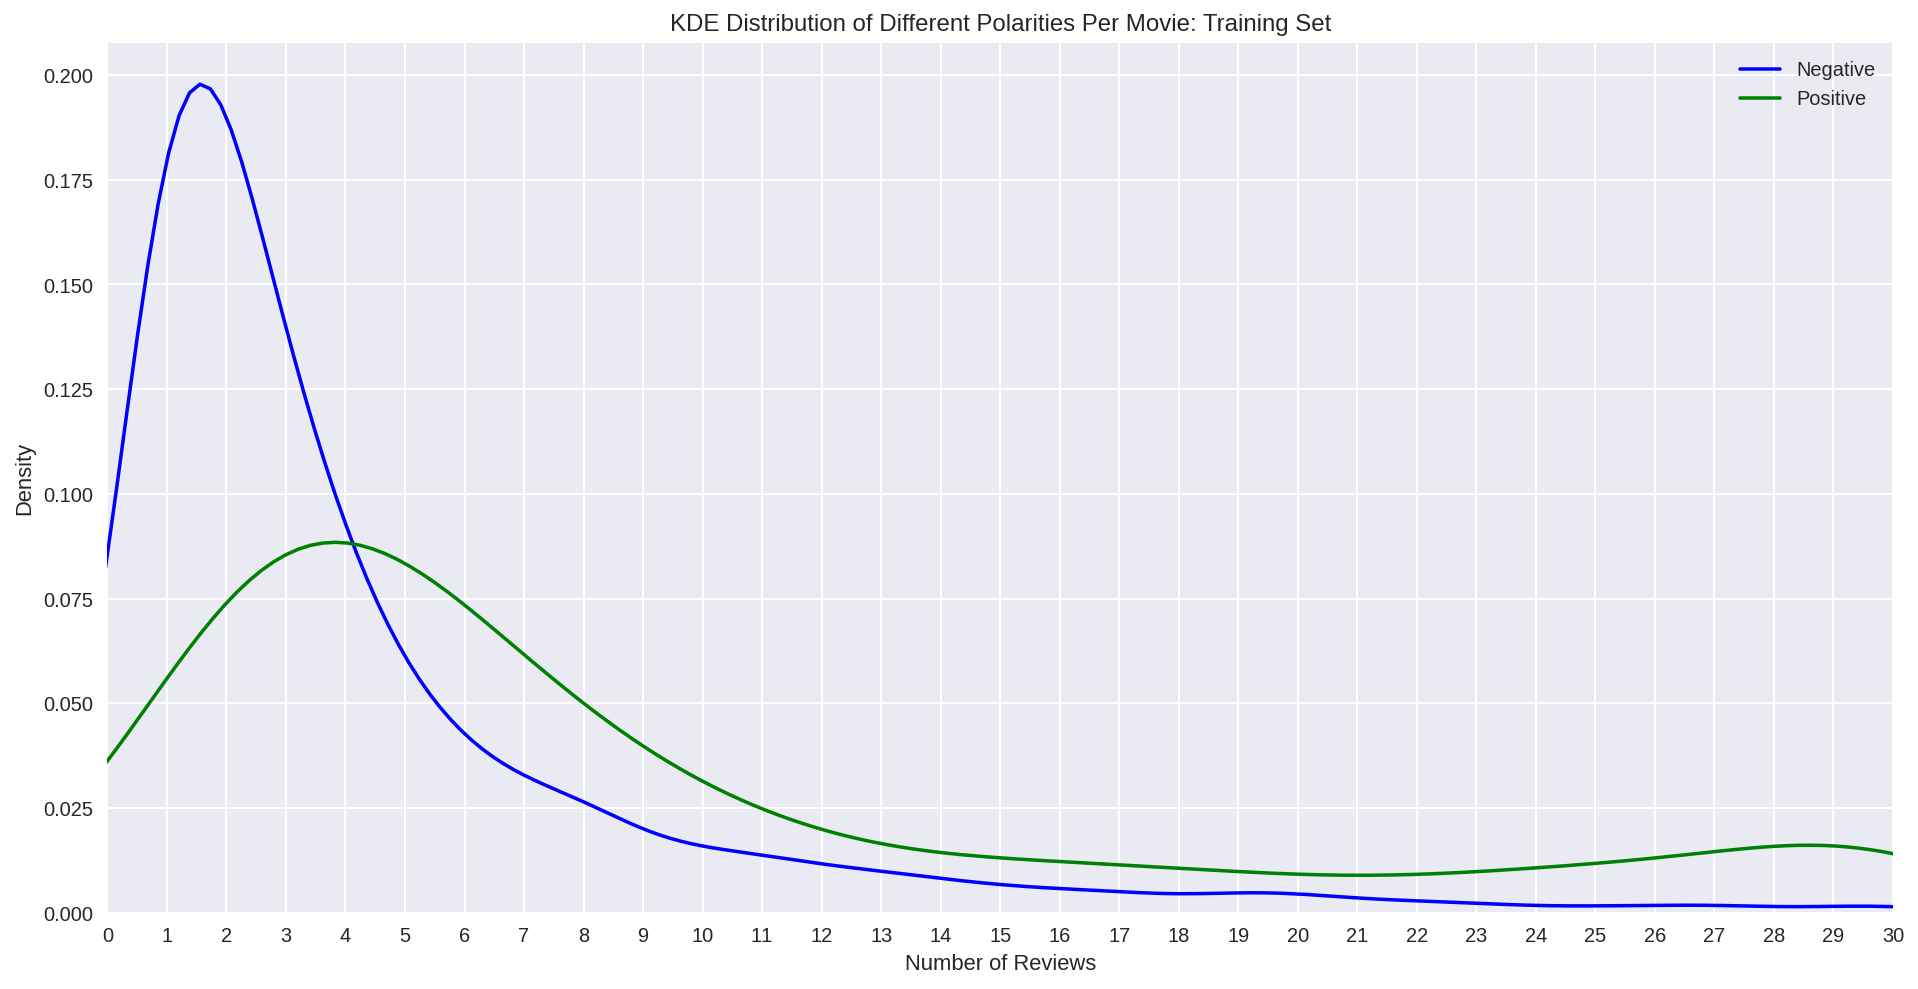

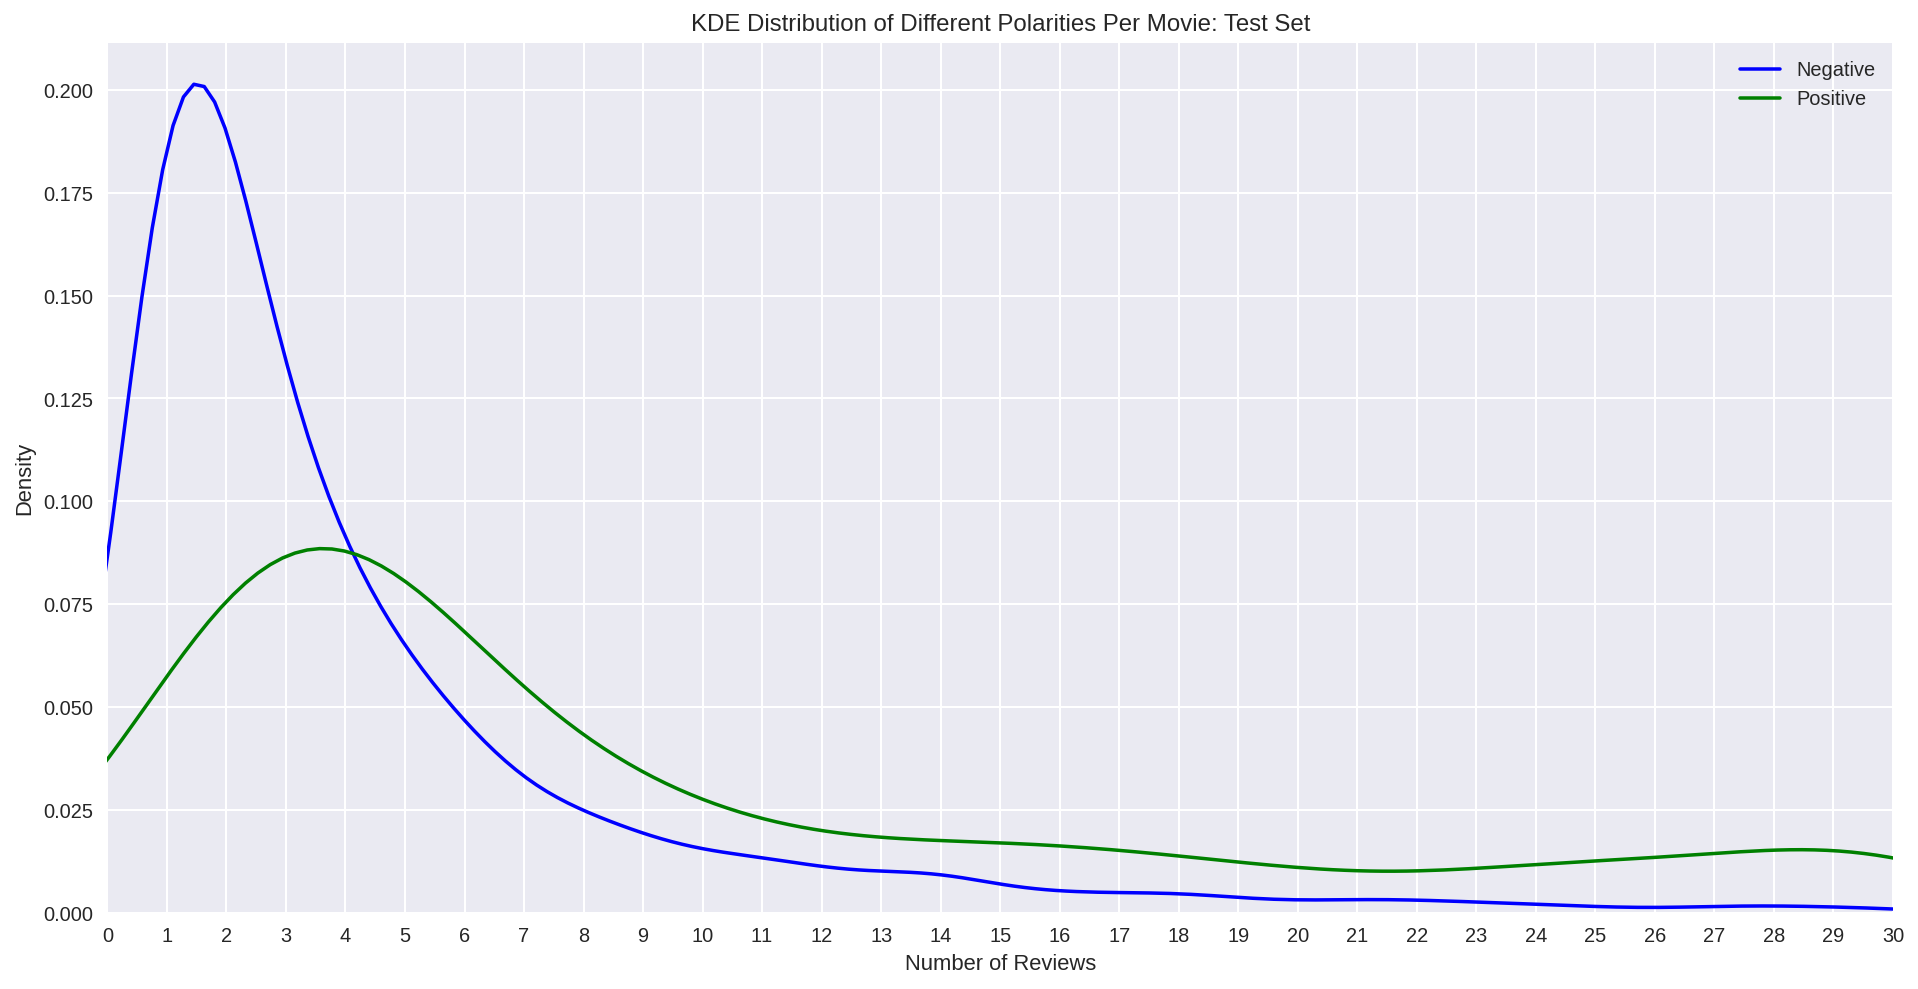

In [28]:
fig1, ax1 = plt.subplots(figsize = (16, 8))

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color = 'blue', label = 'Negative', ax = ax1)
sns.kdeplot(dft[1], color = 'green', label = 'Positive', ax = ax1)
ax1.legend()
ax1.set_title('KDE Distribution of Different Polarities Per Movie: Training Set')
ax1.set_xlabel('Number of Reviews')
ax1.set_xlim(0, 30)
ax1.set_xticks(range(0, 31, 1))


fig2, ax2 = plt.subplots(figsize = (16, 8))

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color = 'blue', label = 'Negative', ax = ax2)
sns.kdeplot(dft[1], color = 'green', label = 'Positive', ax = ax2)
ax2.legend()
ax2.set_title('KDE Distribution of Different Polarities Per Movie: Test Set')
ax2.set_xlabel('Number of Reviews')
ax2.set_xlim(0, 30)
ax2.set_xticks(range(0, 31, 1))

plt.show()

Wonderful! The above bar graphs and KDE plots show that the training set and the test set have very similar distributions of negative and positive reviews!

# Section 3: Evaluation Procedure <a id=5></a>

Composing an evaluation routine which can be used for all models in this project

In [29]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize = (20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

# Section 4: Normalization <a id=6></a>

The models will work best if the texts are in lowercase and without any digits, punctuations marks, etc.

In [30]:
def clear_text(text):
    cleared_text = re.sub(r'[^a-zA-z\']', ' ', text)
    cleared_text = " ".join(cleared_text.split())
    cleared_text = cleared_text.lower()
    return cleared_text

In [31]:
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])

def lemmatize(text):
    text = nlp(text)
    lemmas = [token.lemma_ for token in text]
    lemmatized_text = " ".join(lemmas)
    return lemmatized_text

In [32]:
df_reviews.insert(loc = 10, column = 'review_cleared', value = df_reviews['review'].apply(clear_text))

In [33]:
df_reviews.insert(loc = 11, column = 'review_cle_&_lem', value = df_reviews['review_cleared'].apply(lemmatize))

# Section 5: Train / Test Split <a id=7></a>

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [34]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_features = df_reviews_train.drop('pos', axis = 1)
train_target = df_reviews_train['pos']

test_features = df_reviews_test.drop('pos', axis = 1)
test_target = df_reviews_test['pos']

print(train_features.shape)
print(train_target.shape)
print()
print(test_features.shape)
print(test_target.shape)

(23615, 16)
(23615,)

(23377, 16)
(23377,)


# Section 6: Working with Models <a id=8></a>

For this section of the project, my instructions include training at least three different models for the given training dataset, and testing <u>EACH</u> of the models using the given test dataset. 

If I successfully find a model that yields an F1 score of at least 0.85 among the first three, then I will not train any models beyond the three.

I have decided that I will not use BERT for this project because though BERT can yield very accurate results, it is very demanding of computational power, and will be very slow on the CPU for the complete dataset.

In [35]:
filler_words = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words = filler_words)

In [36]:
train_corpus = train_features['review_cle_&_lem'].copy()
train_tf_idf = count_tf_idf.fit_transform(train_corpus)

In [37]:
test_corpus = test_features['review_cle_&_lem'].copy()
test_tf_idf = count_tf_idf.transform(test_corpus)

### Model 0 (Dummy Classifier)

It is a great idea to build a dummy classifier model because it can be used to sanity check the other models.

I will set the **strategy** parameter equal to **uniform** (meaning the model makes predictions uniformly at random).

In [38]:
dummy_classifier = DummyClassifier(strategy = 'uniform')
dummy_classifier.fit(train_tf_idf, train_target)

DummyClassifier(strategy='uniform')

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


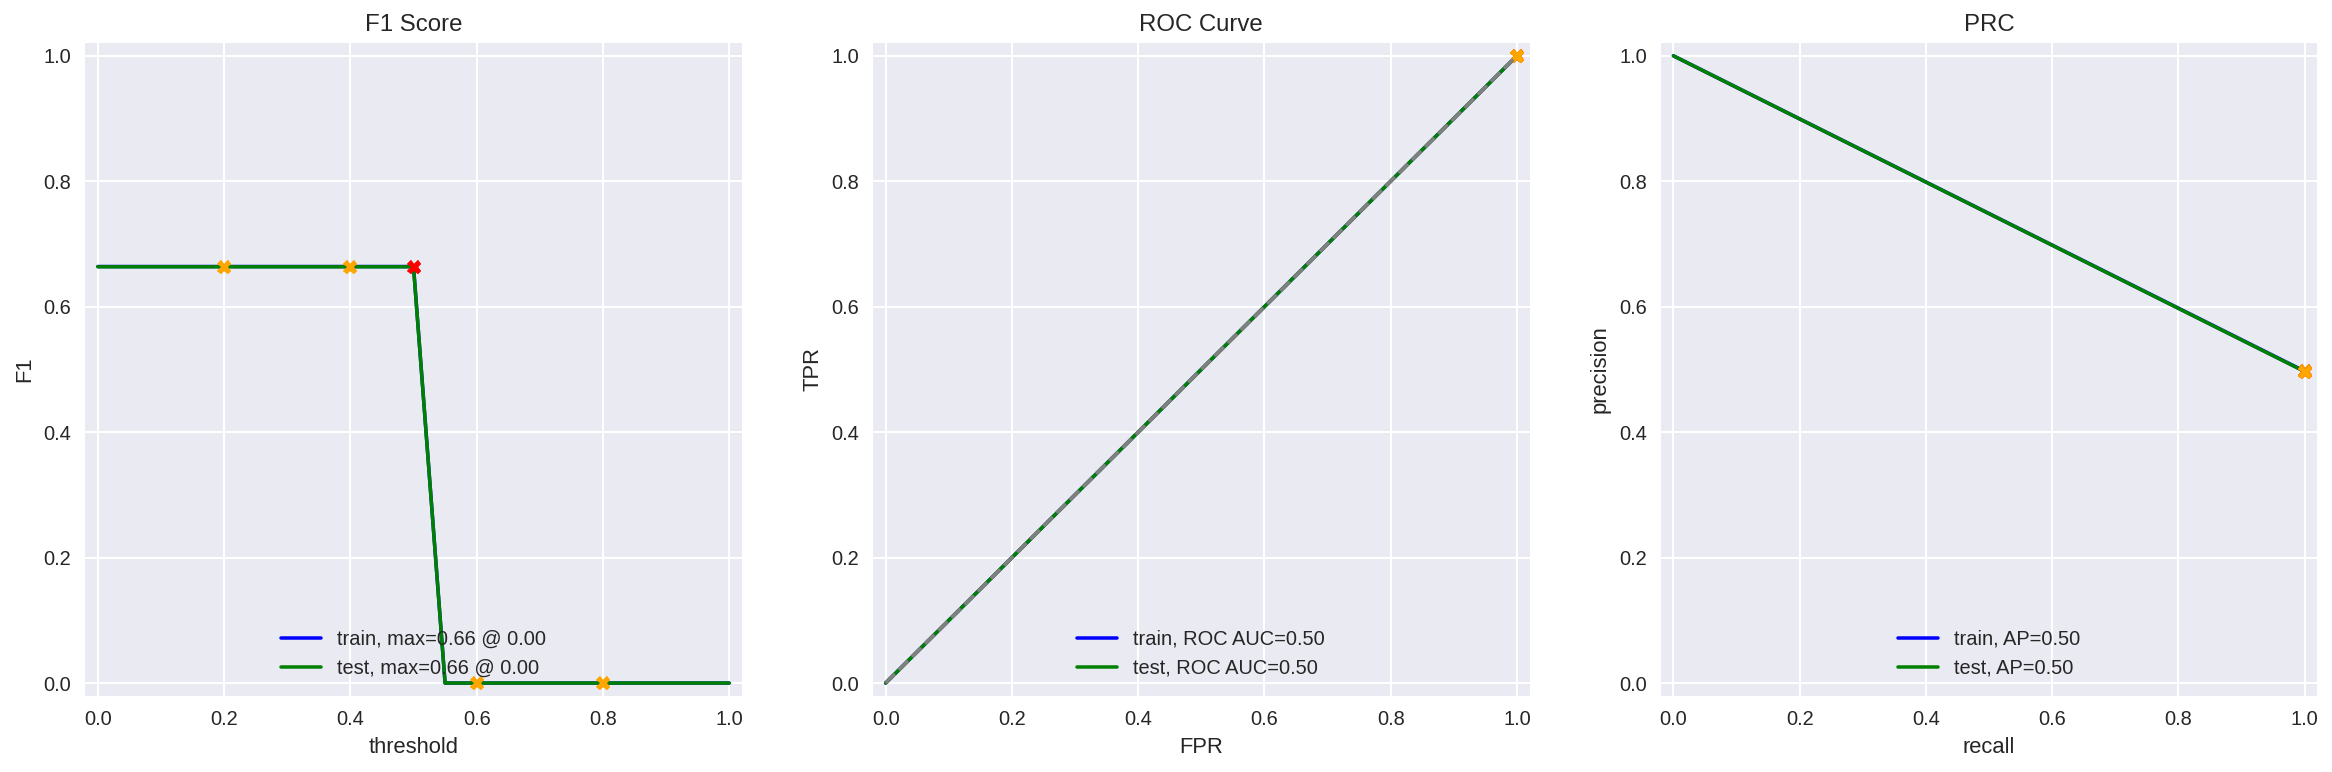

In [39]:
evaluate_model(dummy_classifier, train_tf_idf, train_target, test_tf_idf, test_target)

It makes sense that the F1 score is 0 because this constant model has a 0% success rate with identifying when **pos** equals 1.

### Model 1 (Logistic Regression)

In [40]:
%%time

logistic_regression = LogisticRegression()
logistic_regression.fit(train_tf_idf, train_target)

CPU times: user 2.96 s, sys: 5.32 s, total: 8.28 s
Wall time: 8.37 s


LogisticRegression()

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95
CPU times: user 565 ms, sys: 48 ms, total: 613 ms
Wall time: 685 ms


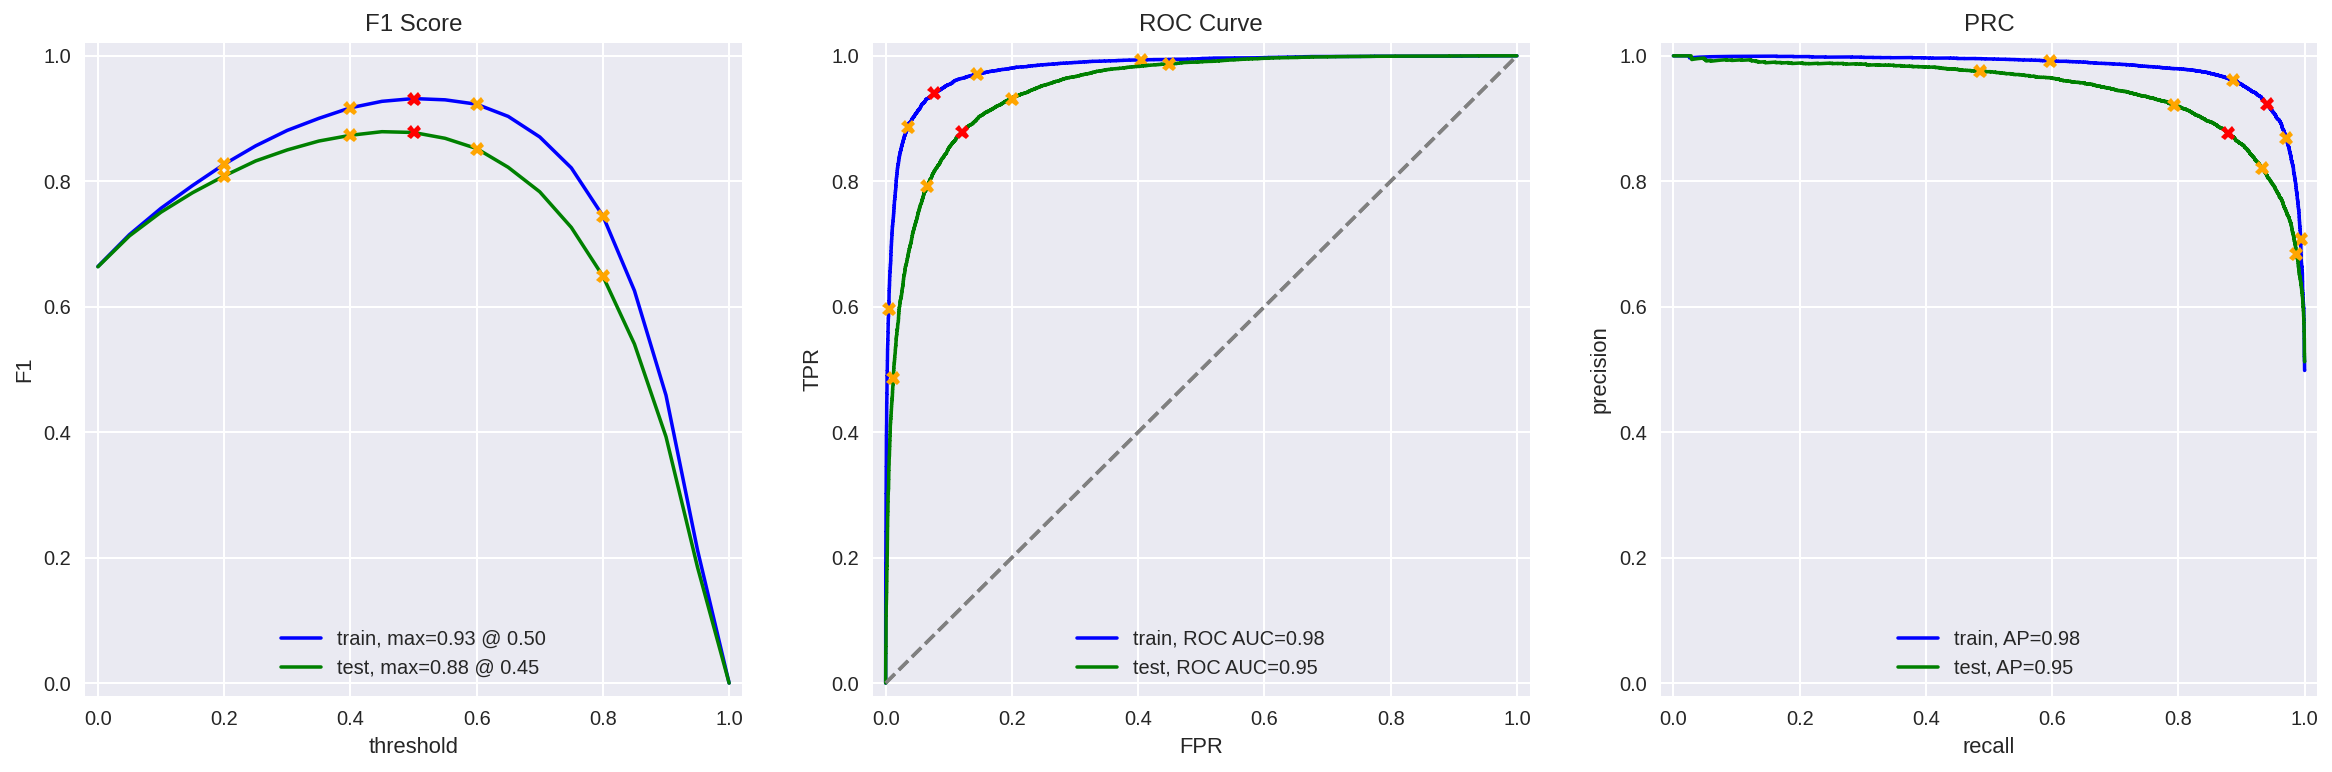

In [41]:
%%time

evaluate_model(logistic_regression, train_tf_idf, train_target, test_tf_idf, test_target)

Great! This model acquired an F1 score of 0.88 on the test set, which is greater than 0.85, the minimum acceptable F1 score. I will still build two more models, because that is what is being asked of me, but it is comforting to know that I have already found a good enough model.

0.88 is a little less than 0.93, the F1 score of the training set, but this difference is understandable because the training set was used to train the model, and hence "common sense" will tell you that the model should be more accurate at predicting the training set than any other.

### Model 2 (LGBMClassifier)

In [42]:
%%time

lgbm_classifier = LGBMClassifier()
lgbm_classifier.fit(train_tf_idf, train_target)

CPU times: user 53.6 s, sys: 374 ms, total: 54 s
Wall time: 56.1 s


LGBMClassifier()

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94
CPU times: user 1.89 s, sys: 0 ns, total: 1.89 s
Wall time: 3.31 s


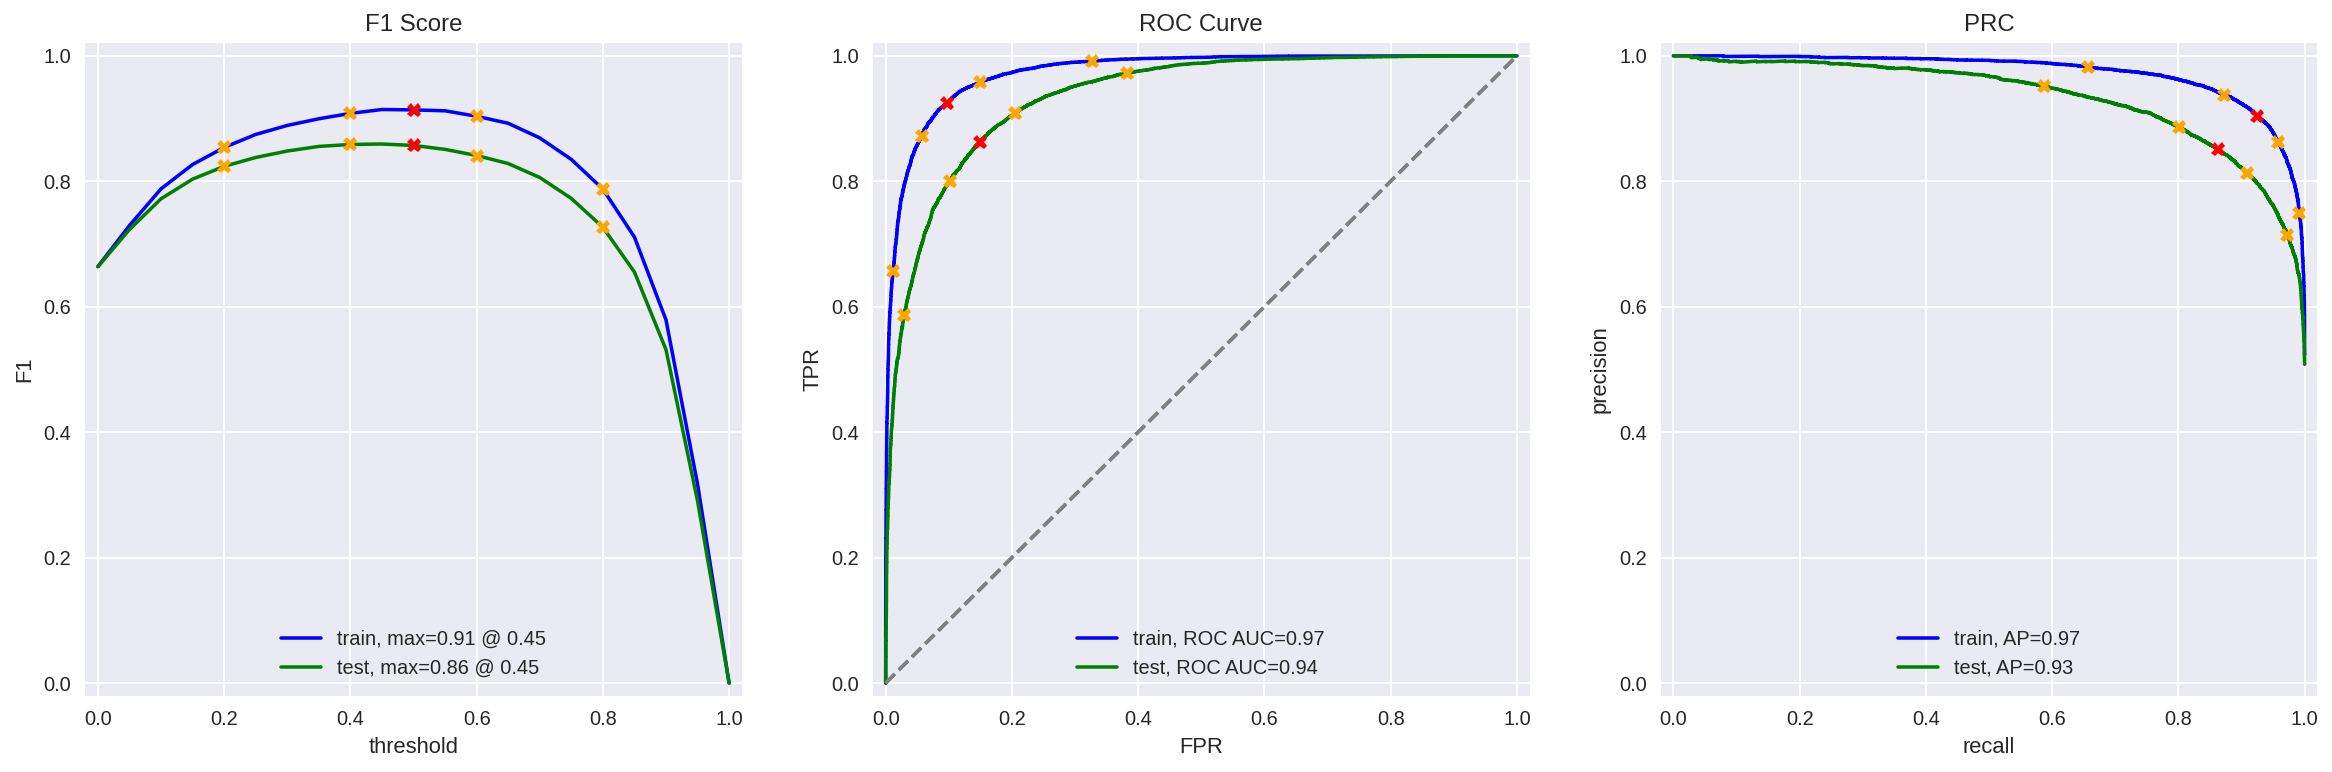

In [43]:
%%time

evaluate_model(lgbm_classifier, train_tf_idf, train_target, test_tf_idf, test_target)

This LGBM classifier, which has **NOT** been given any hyperparameter tuning, also has a good enough F1 score on the test set, 0.86. However, this F1 score is slightly lower than that of the logistic regression. Interestingly, this LGBM classifier also has a slightly worse F1 score on the training set, 0.91, than the logisitic regression, which has 0.93.

Furthermore, the wall time of this LGBM classifier is much longer than that of the logisitic regression! Fitting the logistic regression and evaluating it takes less than 10 seconds, whereas this takes close to 60 seconds with the LGBM classifier!

In theory, I could do some hyperparameter tuning to the LGBM classifier in order to, hopefully, improve the F1 score on the test set as well as reduce the wall time, but I doubt that I would be able to reduce the wall time to the point that it competes with the logisitic regression model.

Let's move on to the next model.

### Model 3 (Decision Tree Classifier)

In [44]:
%%time

decision_tree = DecisionTreeClassifier()
decision_tree.fit(train_tf_idf, train_target)

CPU times: user 38.9 s, sys: 19.1 ms, total: 39 s
Wall time: 1min 57s


DecisionTreeClassifier()

          train  test
Accuracy    1.0  0.71
F1          1.0  0.71
APS         1.0  0.64
ROC AUC     1.0  0.71
CPU times: user 701 ms, sys: 0 ns, total: 701 ms
Wall time: 714 ms


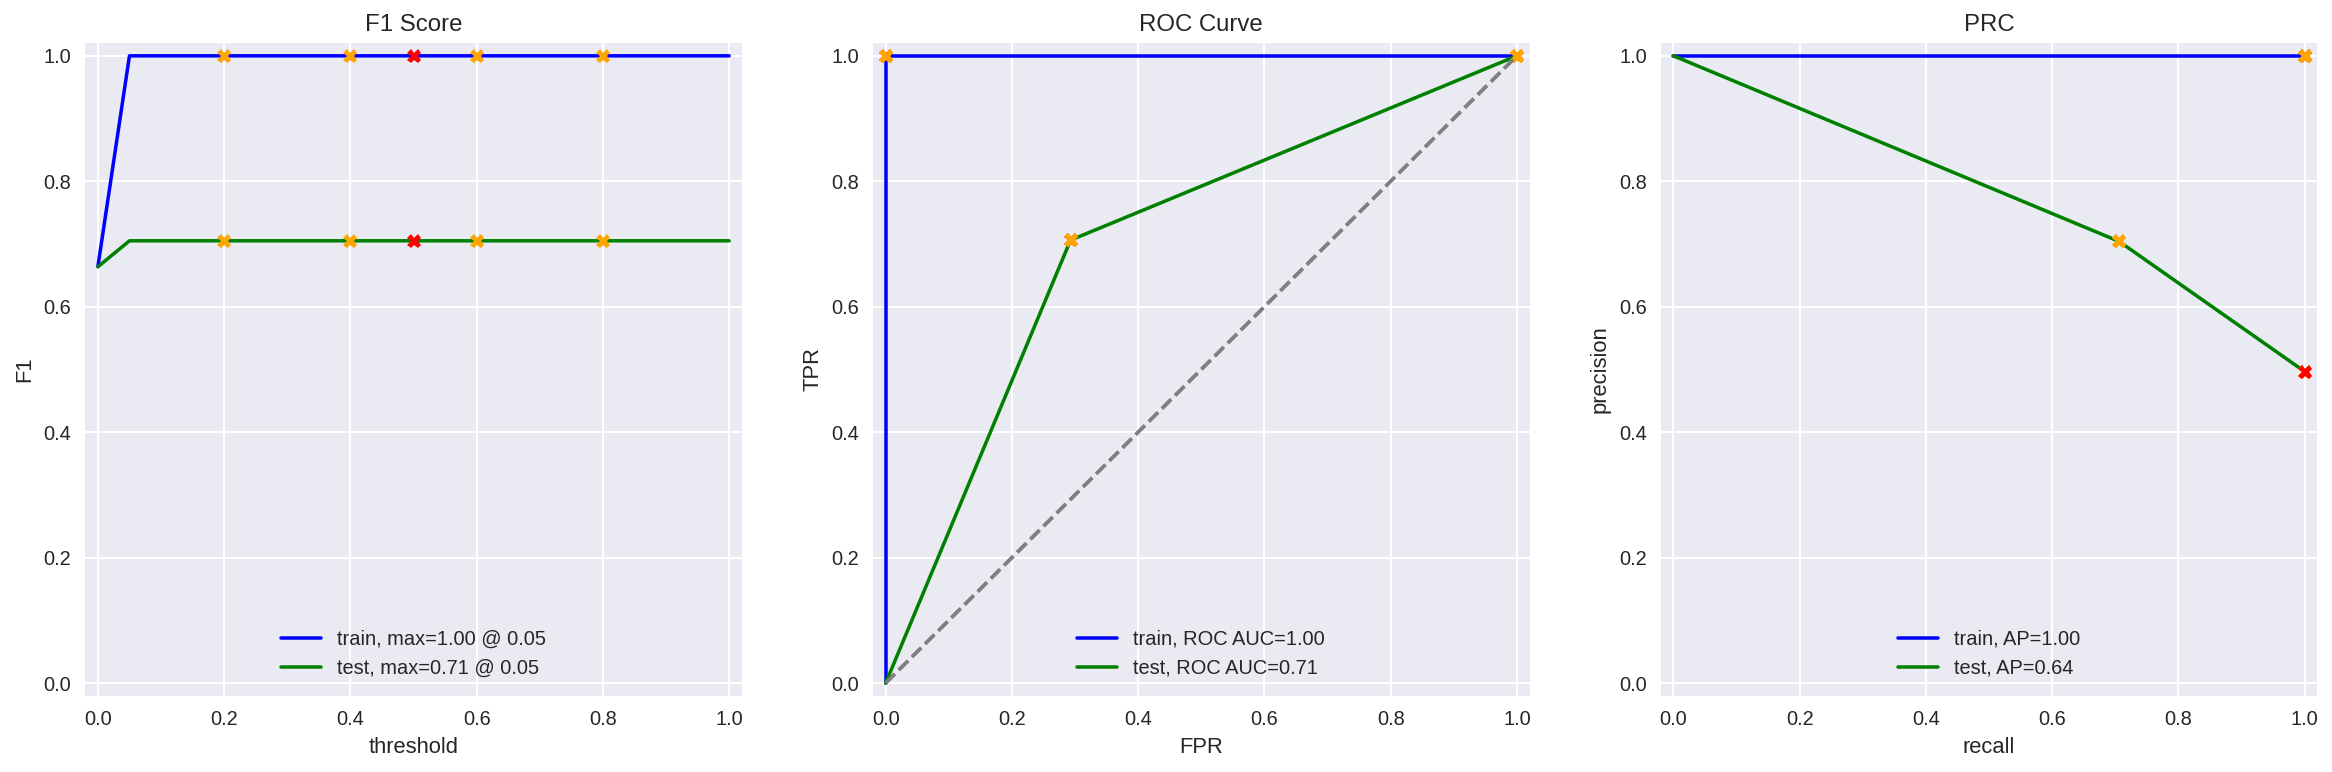

In [45]:
%%time

evaluate_model(decision_tree, train_tf_idf, train_target, test_tf_idf, test_target)

Unfortunately, this model is the worst one yet. It has a relatively slow wall time (though not as bad as the LGBM classifier), and its F1 score on the test set is 0.70, far below the 0.85 (the minimum acceptable F1 score). The fact that all four metric values on the training set are 1.0 strongly suggests that this model is overfitting the training set. I am curious to try improving this model using hyperparameter tuning.

In [46]:
%%time

decision_tree_tuned = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 4, 
                                             min_samples_split = 6, random_state = 12345)

decision_tree_tuned.fit(train_tf_idf, train_target)

CPU times: user 5.13 s, sys: 41 µs, total: 5.13 s
Wall time: 5.15 s


DecisionTreeClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=6,
                       random_state=12345)

          train  test
Accuracy   0.78  0.74
F1         0.80  0.77
APS        0.79  0.72
ROC AUC    0.84  0.78
CPU times: user 568 ms, sys: 3.42 ms, total: 572 ms
Wall time: 577 ms


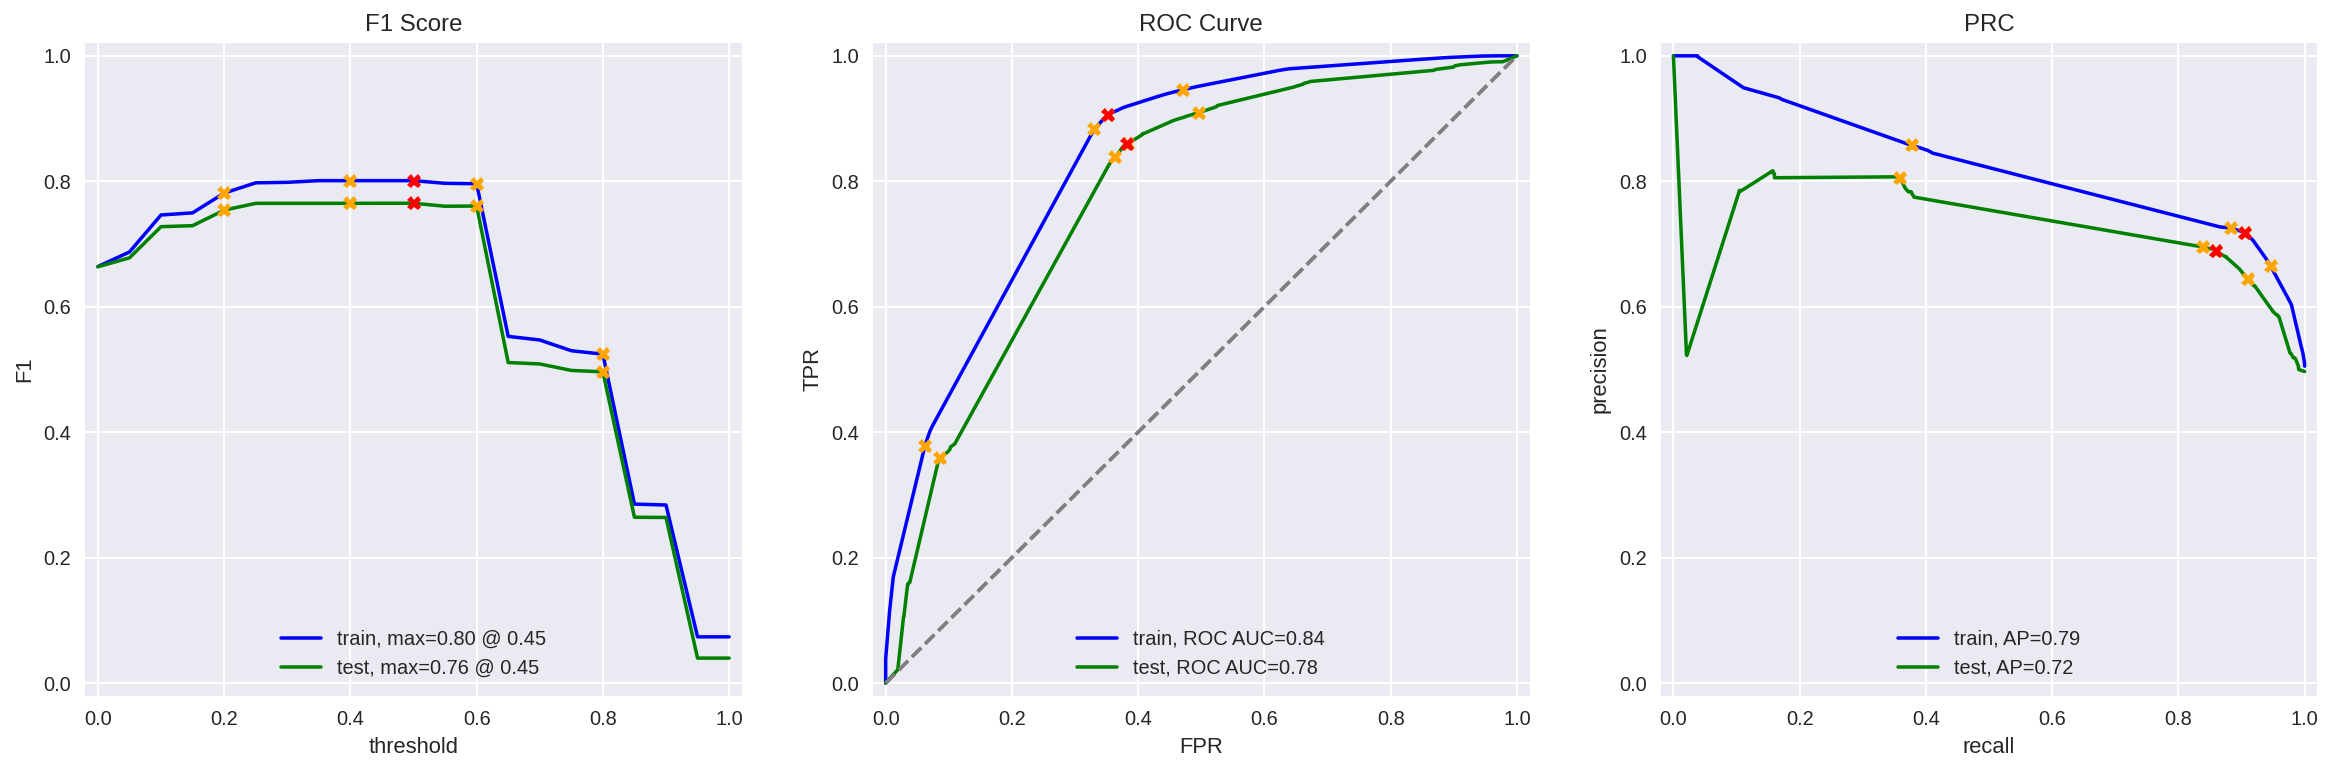

In [47]:
%%time

evaluate_model(decision_tree_tuned, train_tf_idf, train_target, test_tf_idf, test_target)

I deliberately chose to toy around with the max_depth, min_samples_leaf, and min_samples_split values because these hyperparameters are known for helping with reducing overfitting.

Though the wall time has been reduced greatly, and there appears to be much less (if any) overfitting (as evidenced by how similar the training set's metric values are to those of the test set), this tuned decision tree still does not have a good enough F1 score on the test set.  

Perhaps I should have expected this to happen, because going from an F1 score of 0.7 to at least 0.85 is a **BIG** jump, big to the point of being very difficult, maybe even impossible, to acquire.

# Section 7: My Reviews <a id=9></a>

Let's see how the models do with the reviews contained within the **my_reviews** dataframe in the next line.

In [48]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns = ['review'])

The **my_reviews** dataframe has 8 reviews. The 1st, 2nd, 4th, and 7th are negative, whereas the 3rd, 5th, 6th, and 8th are positive. Well, to be precise, I would describe the 6th review as "slightly positive". The reviewer uses the word "decent" as well as "I could see myself going to see it again", while also saying that the movie has its "downsides". I would not be surprised if the models struggle with classifying the 6th review.

Let's add columns to this dataframe, columns that will normalize the text as well as indicate which reviews are positive and which are negative.

In [49]:
my_reviews['review_cleared'] = my_reviews['review'].apply(clear_text)
my_reviews['review_cle_&_lem'] = my_reviews['review_cleared'].apply(lemmatize)
my_reviews['pos'] = [0, 0, 1, 0, 1, 1, 0, 1]

display(my_reviews)

,review,review_cleared,review_cle_&_lem,pos
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie,I do not simply like it not my kind of movie,0
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...,well I be bored and feel asleep in the middle ...,0
2,I was really fascinated with the movie,i was really fascinated with the movie,I be really fascinated with the movie,1
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...,even the actor look really old and disinterest...,0
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...,I do not expect the reboot to be so good write...,1
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...,the movie have its upside and downside but I f...,1
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...,what a rotten attempt at a comedy not a single...,0
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...,launch on netflix be a brave move I really app...,1


Everything looks good!

### Model 1 (Logistic Regression)

In [50]:
texts_lr = my_reviews['review_cle_&_lem'].copy()

In [51]:
my_reviews_pred_prob_lr = logistic_regression.predict_proba(count_tf_idf.transform(texts_lr))[:, 1]

for i, review in enumerate(texts_lr.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_lr[i]:.2f}: {review}')

0.21: I do not simply like it not my kind of movie
0.12: well I be bored and feel asleep in the middle of the movie
0.49: I be really fascinated with the movie
0.10: even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.27: I do not expect the reboot to be so good writer really care about the source material
0.50: the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.03: what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.92: launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


Keep in mind that a probability value less than 0.5 means the review is thought to be negative by the model, and in contrast if the probability value is more than 0.5 it means the review is thought to be positive.

The logistic regression model correctly classified the four negative reviews. It also correctly classified the eighth review as positive, and I would argue that 0.50 is an appropriate value to give the sixth review, which is very mixed.

Furthermore, this model **ALMOST** classified the third review as positive, since 0.49 is so close to being over 0.5, but, interestingly, the model gave the fifth review a probability value of 0.27 even though it is positive.

Hence, I would say that the logistic regression model is 6/8 = 75% accurate here.

### Model 2 (LGBMClassifier)

In [52]:
texts_lgbm = my_reviews['review_cle_&_lem'].copy()

In [53]:
my_reviews_pred_prob_lgbm = lgbm_classifier.predict_proba(count_tf_idf.transform(texts_lgbm))[:, 1]

for i, review in enumerate(texts_lgbm.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_lgbm[i]:.2f}: {review}')

0.56: I do not simply like it not my kind of movie
0.36: well I be bored and feel asleep in the middle of the movie
0.58: I be really fascinated with the movie
0.34: even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.63: I do not expect the reboot to be so good writer really care about the source material
0.69: the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.18: what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.77: launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


Interestingly, the LGBM classifier did better than the logistic regression. The only review that is incorrectly classified is the first one; a probability of 0.56 suggests that the review is likely to be positive, but in reality the review is negative.

Hence, the LGBM classifier is 7/8 = 87.5% accurate here.

I must stress, however, that this result is not meant to suggest that the LGBM classifier is better! Earlier in the project, the logisitic regression and the LGBM classifier got very similar F1 scores on a **MUCH** large dataset.

More specifically, the logisitic regression performed slightly better. Furthermore, 8 is such a **SMALL** number of reviews, and it is normal for an otherwise inferior model to, for lack of better words, get "lucky" and perform better than the superior model on a small dataset.

### Model 3 (Decision Tree Classifier)

In [54]:
texts_dt = my_reviews['review_cle_&_lem'].copy()

In [55]:
my_reviews_pred_prob_dt = decision_tree.predict_proba(count_tf_idf.transform(texts_dt))[:, 1]

for i, review in enumerate(texts_dt.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_dt[i]:.2f}: {review}')

1.00: I do not simply like it not my kind of movie
0.00: well I be bored and feel asleep in the middle of the movie
1.00: I be really fascinated with the movie
1.00: even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.00: I do not expect the reboot to be so good writer really care about the source material
1.00: the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.00: what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
1.00: launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


Interesting... all of the probability values are either 0 or 1. I wonder if this would still be true if the dataframe had many more than 8 reviews.

For what it is worth, this model is 4/8 = 50% accurate because the third, sixth, seventh, and eighth reviews are correctly classified.

I wonder how the tuned decision tree classifier will do?

In [56]:
texts_dt_tuned = my_reviews['review_cle_&_lem'].copy()

In [57]:
my_reviews_pred_prob_dt_tuned = decision_tree_tuned.predict_proba(count_tf_idf.transform(texts_dt_tuned))[:, 1]

for i, review in enumerate(texts_dt_tuned.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_dt_tuned[i]:.2f}: {review}')

0.65: I do not simply like it not my kind of movie
0.65: well I be bored and feel asleep in the middle of the movie
0.65: I be really fascinated with the movie
0.65: even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.65: I do not expect the reboot to be so good writer really care about the source material
0.65: the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.65: what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.65: launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


What a bizarre result! All of them are 0.65? 

Technically speaking, this model is 4/8 = 50% accurate, but this is a dubious result given that all of the probability values are the same.

Perhaps the bizarre results of both decision tree models are to be expected, due to their relatively low F1 scores.

# Conclusion <a id=10></a>

The goal of this project was to use a dataset of IMDB movie reviews to train a model that can automatically detect negative reviews. This model is intended to be used by the Film Junky Union, a community of movie enthusiasts, and needs an F1 score of at least 0.85 in order to be considered accurate enough.

In total, I built three different models (a logistic regression, an LGBM classifier, and a decision tree classifier), and the best one is the logisitic regression model, whose F1 score on the training set was 0.93 and whose F1 score on the test set was 0.88.

Prior to building the models, I preprocessed the data (e.g. dropping certain columns and rows) and did exploratory data analysis (EDA). The most important observation I made throughout the EDA is that the distributions of the training set are very similar to those of the test set (specifically, the distribution of ratings on a scale of 1 to 10, and the distribution of the polarity of the reviews by year).

After preprocessing and EDA, I added a column to the dataframe that contains "cleared" versions of the reviews. By "cleared", I mean the only remaining characters were lowercase letters and apostrophes. I then added yet another column, this one containing lemmatized versions of the "cleared" reviews. 

Lastly, I applied a TfidfVectorizer to the lemmatized reviews, which removed the stop words, and the results of the TfidfVectorizer were used to train and test the three models.